In [2]:
import pandas as pd
import numpy as np

In [3]:
# load data
# computational bg from mp
df_mp = pd.read_csv('selected_data.csv')

# experimental bg from matbench
df_matbench = pd.read_json('matbench_expt_gap.json', orient='index').T
# Expand the "data" column into two separate columns
df_matbench[["formula", "bg_expt"]] = pd.DataFrame(df_matbench["data"].tolist(), index=df_matbench.index)

# Drop unnecessary columns, including the "category" column
df_matbench = df_matbench.drop(columns=["data", "index", "columns"])


# experimental bg from ds2
# Reload JSON file
df_ds2 = pd.read_json("data/ds2.json", orient="index")

# Reset index to move 'mpids' into a separate column
df_ds2 = df_ds2.reset_index()




# Rename the columns for clarity
df_ds2.columns = ["mpids", "formula", "bg_mp", "bg"]

# Assuming df_mp has been loaded, we need to merge df_ds2 with df_mp to get the formula
df_ds2 = df_ds2.merge(df_mp[["mpids"]], on="mpids", how="left")


# load data from bandgapdatabase1
df_bandgap = pd.read_csv('bandgap_data_median.csv')

In [4]:
df_matbench

,formula,bg_expt
0,Ag(AuS)2,0.00
1,Ag(W3Br7)2,0.00
2,Ag0.5Ge1Pb1.75S4,1.83
3,Ag0.5Ge1Pb1.75Se4,1.51
4,Ag2BBr,0.00
...,...,...
4599,ZrTaN3,1.72
4600,ZrTe,0.00
4601,ZrTi2O,0.00
4602,ZrTiF6,0.00


In [5]:

# Ensure df_mp is sorted so that the lowest 'formation_energy_per_atom' is selected
df_mp_sorted = df_mp.sort_values(by="formation_energy_per_atom")

# Drop duplicates based on 'formula', keeping the one with lowest 'formation_energy_per_atom'
df_mp_matbench = df_mp_sorted.drop_duplicates(subset="formula", keep="first")

# Merge df_cleaned with the filtered df_mp to retain only the lowest formation energy per formula
df_merged = df_matbench.merge(df_mp_matbench, on="formula", how="left")
df_matbench = df_merged.dropna(subset=['mpids'])

# filter ds2
df_ds2 = df_ds2[df_ds2["mpids"].isin(df_mp["mpids"])]

# Filter each dataframe to keep only samples with band gap in the range 0.5 to 5
# df_filtered: data from matbench
# df_bandgap: data from bandgapdatabase1
# df_ds2: data from ds2

df_matbench = df_matbench[(df_matbench["bg_expt"] >= 0.5) & (df_matbench["bg_expt"] <= 5)]
df_bandgap = df_bandgap[(df_bandgap["Value"] >= 0.5) & (df_bandgap["Value"] <= 5)]
df_ds2 = df_ds2[(df_ds2["bg"] >= 0.5) & (df_ds2["bg"] <= 5)]

In [6]:
# Convert mpids columns to sets for easy comparison
mpids_matbench = set(df_matbench["mpids"])
mpids_bandgap = set(df_bandgap["mpids"])
mpids_ds2 = set(df_ds2["mpids"])

# Compute overlaps
overlap_matbench_bandgap = len(mpids_matbench & mpids_bandgap)
overlap_matbench_ds2 = len(mpids_matbench & mpids_ds2)
overlap_bandgap_ds2 = len(mpids_bandgap & mpids_ds2)

# Display results
overlap_summary = pd.DataFrame({
    ("Dataset 1", "Dataset 2"): [
        ("df_filtered", "df_bandgap"),
        ("df_filtered", "df_ds2"),
        ("df_bandgap", "df_ds2"),
    ],
    "Number of Overlaps": [
        overlap_matbench_bandgap,
        overlap_matbench_ds2,
        overlap_bandgap_ds2,
    ]
})

overlap_summary

,"(Dataset 1, Dataset 2)",Number of Overlaps
0,"(df_filtered, df_bandgap)",392
1,"(df_filtered, df_ds2)",149
2,"(df_bandgap, df_ds2)",166


In [7]:
# # i need a overlap of df_mp_filtered with df_bandgap
# # Convert mpids columns to sets for easy comparison
# mpids_mp_filtered = set(df_mp_filtered["mpids"])
# # Compute overlaps
# overlap_mp_filtered_bandgap = len(mpids_mp_filtered & mpids_bandgap)
# # Display results
# overlap_mp_filtered_bandgap_summary = pd.DataFrame({
#     ("Dataset 1", "Dataset 2"): [
#         ("df_mp_filtered", "df_bandgap"),
#     ],
#     "Number of Overlaps": [
#         overlap_mp_filtered_bandgap,
#     ]
# })
# overlap_mp_filtered_bandgap_summary

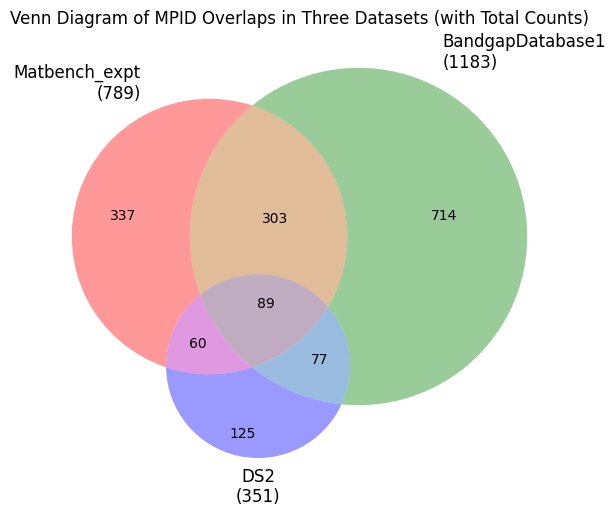

In [8]:
# Re-import necessary libraries since execution state was reset
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Assuming df_filtered, df_bandgap, and df_ds2 have been reloaded

# Convert mpids columns to sets for easy comparison
mpids_matbench = set(df_matbench["mpids"])
mpids_bandgap = set(df_bandgap["mpids"])
mpids_ds2 = set(df_ds2["mpids"])

# Get total counts for each dataset
count_matbench = len(mpids_matbench)
count_bandgap = len(mpids_bandgap)
count_ds2 = len(mpids_ds2)

# Create a Venn diagram
plt.figure(figsize=(8, 6))
venn = venn3([mpids_matbench, mpids_bandgap, mpids_ds2], 
             set_labels=(f"Matbench_expt\n({count_matbench})", 
                         f"BandgapDatabase1\n({count_bandgap})", 
                         f"DS2\n({count_ds2})"))

plt.title("Venn Diagram of MPID Overlaps in Three Datasets (with Total Counts)")
# save the figure
plt.savefig('venn_diagram.png')
plt.show()



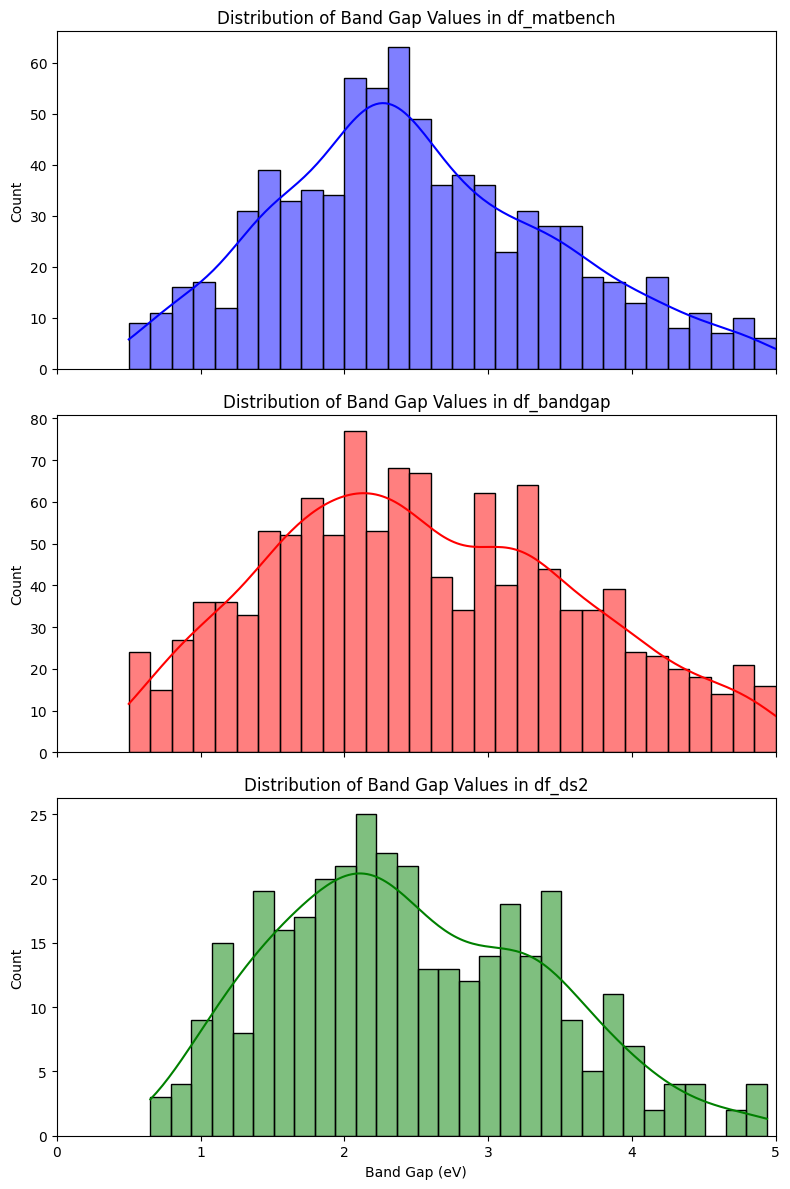

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set fixed x and y axis range
x_range = (0, 5)  # Band gap range from 0 to 5 eV
y_range = (0, None)  # Let y-axis adjust based on data density

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot distribution for df_filtered
sns.histplot(df_matbench["bg_expt"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Band Gap Values in df_matbench")
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)
axes[0].set_xlabel("Band Gap (eV)")

# Plot distribution for df_bandgap
sns.histplot(df_bandgap["Value"], bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Band Gap Values in df_bandgap")
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)
axes[1].set_xlabel("Band Gap (eV)")

# Plot distribution for df_ds2
sns.histplot(df_ds2["bg"], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribution of Band Gap Values in df_ds2")
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)
axes[2].set_xlabel("Band Gap (eV)")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()



In [10]:
# Convert mpids columns to sets for easy comparison
mpids_filtered = set(df_matbench["mpids"])
mpids_bandgap = set(df_bandgap["mpids"])
mpids_ds2 = set(df_ds2["mpids"])

# Find overlap sets
overlap_filtered_bandgap = mpids_filtered & mpids_bandgap
overlap_filtered_ds2 = mpids_filtered & mpids_ds2
overlap_bandgap_ds2 = mpids_bandgap & mpids_ds2
overlap_all_three = mpids_filtered & mpids_bandgap & mpids_ds2

# Merge DataFrames to keep band gap values from both sources
df_overlap_matbench_bandgap = df_matbench[df_matbench["mpids"].isin(overlap_filtered_bandgap)].merge(
    df_bandgap[["mpids", "Value"]], on="mpids", how="left", suffixes=("_filtered", "_bandgap")
)

df_overlap_matbench_ds2 = df_matbench[df_matbench["mpids"].isin(overlap_filtered_ds2)].merge(
    df_ds2[["mpids", "bg"]], on="mpids", how="left", suffixes=("_filtered", "_ds2")
)

df_overlap_bandgap_ds2 = df_bandgap[df_bandgap["mpids"].isin(overlap_bandgap_ds2)].merge(
    df_ds2[["mpids", "bg"]], on="mpids", how="left", suffixes=("_bandgap", "_ds2")
)

df_overlap_all_three = df_matbench[df_matbench["mpids"].isin(overlap_all_three)].merge(
    df_bandgap[["mpids", "Value"]], on="mpids", how="left", suffixes=("_filtered", "_bandgap")
).merge(
    df_ds2[["mpids", "bg"]], on="mpids", how="left", suffixes=("", "_ds2")
)

# Display the first few rows of each DataFrame
df_overlap_matbench_bandgap.head()




,formula,bg_expt,mpids,elements,is_stable,theoretical,band_gap,formation_energy_per_atom,Value
0,Ag8GeS6,1.18,mp-9770,"[Element Ag, Element Ge, Element S]",True,False,0.6102,-0.326872,1.45
1,AgBiS2,0.90,mp-29678,"[Element Ag, Element Bi, Element S]",False,False,0.5212,-0.289343,0.98
2,AgBr,2.52,mp-23231,"[Element Ag, Element Br]",True,False,0.7304,-0.659621,2.60
3,AgP15,1.47,mp-1195243,"[Element Ag, Element P]",False,False,1.2132,0.002923,1.38
4,AgPd(IO3)3,1.50,mp-1193499,"[Element Ag, Element I, Element O, Element Pd]",False,False,1.4039,-0.736863,1.50


In [11]:
# # Comparison of Band Gap Distributions: df_bandgap vs. Not in df_bandgap
# # Convert mpids columns to sets for easy comparison
# mpids_bandgap = set(df_bandgap["mpids"])

# # Find data that is NOT in df_bandgap (from df_filtered and df_ds2)
# df_not_in_bandgap = pd.concat([df_filtered, df_ds2], ignore_index=True)
# df_not_in_bandgap = df_not_in_bandgap[~df_not_in_bandgap["mpids"].isin(mpids_bandgap)]

# # Plot distributions
# plt.figure(figsize=(8, 6))

# # Plot distribution for df_bandgap
# sns.histplot(df_bandgap["Value"], bins=30, kde=True, label="df_bandgap", color="red")

# # Plot distribution for data not in df_bandgap
# sns.histplot(df_not_in_bandgap["bg_expt"].fillna(df_not_in_bandgap["bg"]), bins=30, kde=True, label="Not in df_bandgap", color="blue")

# plt.title("Comparison of Band Gap Distributions: df_bandgap vs. Not in df_bandgap")
# plt.xlabel("Band Gap (eV)")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

In [12]:
df_ds2

,mpids,formula,bg_mp,bg
0,mp-390,TiO2,2.0625,3.20
1,mp-2657,TiO2,1.7719,3.02
2,mp-32777,WO3,1.2338,2.76
3,mp-619461,WO3,1.3712,2.73
6,mp-19009,NiO,2.4141,3.54
...,...,...,...,...
501,mp-2979,ZnGeN2,1.6966,3.36
502,mp-1392,ZnP2,0.7480,1.42
503,mp-560588,ZnS,2.0776,3.91
504,mp-13334,ZnSnO3,1.0810,3.90


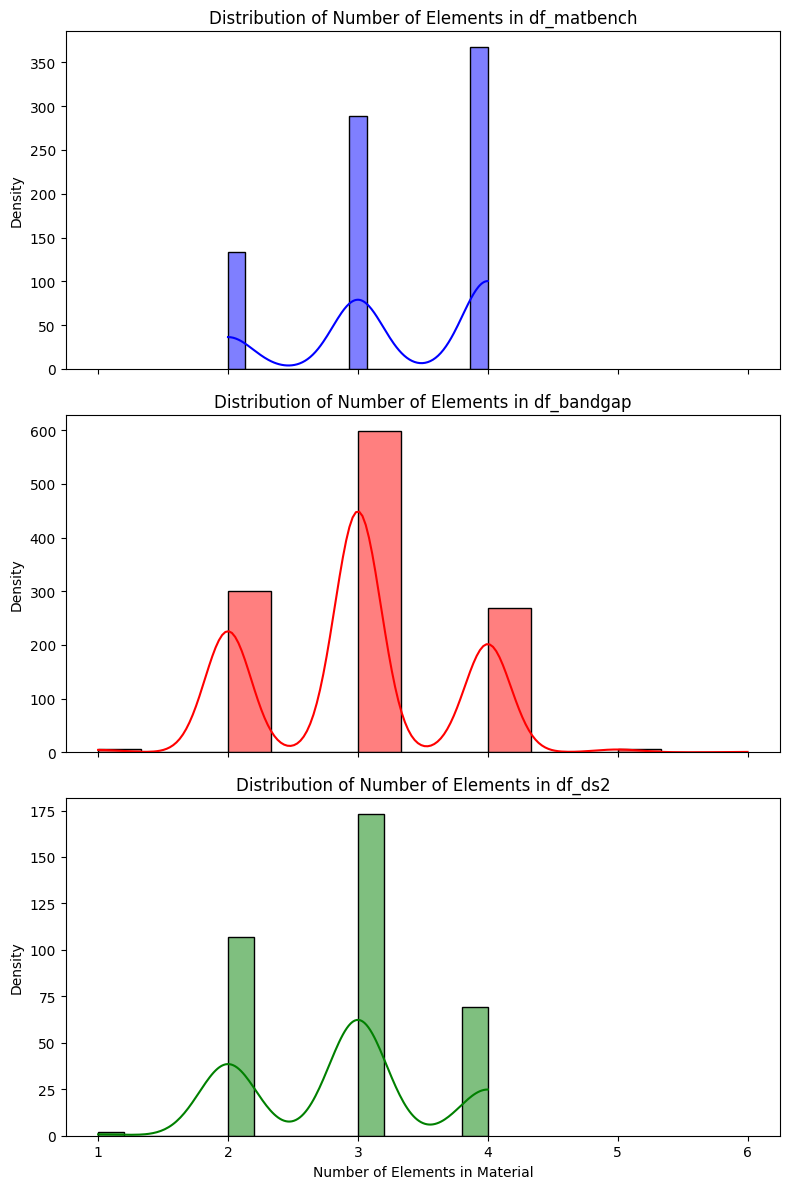

In [13]:

# Function to count the number of elements in the formula
def count_elements(formula):
    return sum(1 for char in formula if char.isupper())  # Count uppercase letters

# Apply the function to count elements for each dataset
df_matbench["num_elements"] = df_matbench["formula"].apply(count_elements)
df_bandgap["num_elements"] = df_bandgap["formula"].apply(count_elements)
df_ds2["num_elements"] = df_ds2["formula"].apply(count_elements)

# Create separate subplots for each dataset
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot distribution for df_matbench
sns.histplot(df_matbench["num_elements"], bins=15, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Number of Elements in df_matbench")
axes[0].set_ylabel("Density")

# Plot distribution for df_bandgap
sns.histplot(df_bandgap["num_elements"], bins=15, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Number of Elements in df_bandgap")
axes[1].set_ylabel("Density")

# Plot distribution for df_ds2
sns.histplot(df_ds2["num_elements"], bins=15, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribution of Number of Elements in df_ds2")
axes[2].set_xlabel("Number of Elements in Material")
axes[2].set_ylabel("Density")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [14]:


# Count the number of materials for each unique element count in each dataset
count_filtered = df_matbench["num_elements"].value_counts().sort_index()
count_bandgap = df_bandgap["num_elements"].value_counts().sort_index()
count_ds2 = df_ds2["num_elements"].value_counts().sort_index()

# Determine the maximum number of elements across all datasets
max_elements = max(count_filtered.index.max(), count_bandgap.index.max(), count_ds2.index.max())

# Create a complete index range for reindexing
element_range = range(1, max_elements + 1)

# Reindex the counts to ensure equal length and fill missing values with 0
count_filtered = count_filtered.reindex(element_range, fill_value=0)
count_bandgap = count_bandgap.reindex(element_range, fill_value=0)
count_ds2 = count_ds2.reindex(element_range, fill_value=0)

# Create a summary table with datasets as rows
summary_table = pd.DataFrame({
    "matbench_expt": count_filtered,
    "BandgapDatabase1": count_bandgap,
    "DS2": count_ds2
}).fillna(0).astype(int)

# Rename the index as "# of Elements"
summary_table.index.name = "# of Elements"


summary_table

,matbench_expt,BandgapDatabase1,DS2
# of Elements,,,
1,0,6,2
2,133,301,107
3,289,599,173
4,367,269,69
5,0,7,0
6,0,1,0


In [15]:
# # Function to count the number of elements in a formula
# def count_elements(formula):
#     return sum(1 for char in formula if char.isupper()) if isinstance(formula, str) else None

# # Ensure the num_elements column is calculated for unique datasets
# if "formula" in df_unique_matbench.columns:
#     df_unique_filtered["num_elements"] = df_unique_filtered["formula"].apply(count_elements)

# if "formula" in df_unique_bandgap.columns:
#     df_unique_bandgap["num_elements"] = df_unique_bandgap["formula"].apply(count_elements)

# if "formula" in df_unique_ds2.columns:
#     df_unique_ds2["num_elements"] = df_unique_ds2["formula"].apply(count_elements)

# # Count the number of materials for each unique element count in each dataset
# count_unique_filtered = df_unique_filtered["num_elements"].value_counts().sort_index()
# count_unique_bandgap = df_unique_bandgap["num_elements"].value_counts().sort_index()
# count_unique_ds2 = df_unique_ds2["num_elements"].value_counts().sort_index()

# # Determine the maximum number of elements across all datasets
# max_elements_unique = max(count_unique_filtered.index.max(), count_unique_bandgap.index.max(), count_unique_ds2.index.max())

# # Create a complete index range for reindexing
# element_range_unique = range(1, max_elements_unique + 1)

# # Reindex the counts to ensure equal length and fill missing values with 0
# count_unique_filtered = count_unique_filtered.reindex(element_range_unique, fill_value=0)
# count_unique_bandgap = count_unique_bandgap.reindex(element_range_unique, fill_value=0)
# count_unique_ds2 = count_unique_ds2.reindex(element_range_unique, fill_value=0)

# # Create a summary table with datasets as rows
# summary_table_unique = pd.DataFrame({
#     "unique_matbench": count_unique_filtered,
#     "unique_bandgapdatabase1": count_unique_bandgap,
#     "unique_ds2": count_unique_ds2
# }).fillna(0).astype(int)

# summary_table_unique

In [16]:
# Merge dataframes on 'mpids' to compare their values
df_merged = df_matbench.merge(df_bandgap, on="mpids", how="inner", suffixes=("_filtered", "_bandgap"))
df_merged = df_merged.merge(df_ds2, on="mpids", how="inner")

# Rename columns for clarity
df_merged.rename(columns={"bg_expt": "df_filtered_bg_expt", 
                          "Value": "df_bandgap_Value", 
                          "bg": "df_ds2_bg"}, inplace=True)

# Calculate differences
df_merged["filtered_vs_bandgap"] = df_merged["df_filtered_bg_expt"] - df_merged["df_bandgap_Value"]
df_merged["filtered_vs_ds2"] = df_merged["df_filtered_bg_expt"] - df_merged["df_ds2_bg"]
df_merged["bandgap_vs_ds2"] = df_merged["df_bandgap_Value"] - df_merged["df_ds2_bg"]

df_merged


,formula_filtered,df_filtered_bg_expt,mpids,elements,is_stable_filtered,theoretical_filtered,band_gap_filtered,formation_energy_per_atom_filtered,num_elements_filtered,formula_bandgap,...,DOI,compound_type,num_elements_bandgap,formula,bg_mp,df_ds2_bg,num_elements,filtered_vs_bandgap,filtered_vs_ds2,bandgap_vs_ds2
0,AgBr,2.52,mp-23231,"[Element Ag, Element Br]",True,False,0.7304,-0.659621,2,AgBr,...,10.1016/j.cej.2013.03.091,Halides,2,AgBr,0.7946,2.7125,2,-0.08,-0.1925,-0.1125
1,Al2Se3,3.10,mp-11674,"[Element Al, Element Se]",True,False,1.8004,-1.008824,2,Al2Se3,...,10.1039/c7tc05311h,Double anions,2,Al2Se3,2.1576,3.1000,2,0.00,0.0000,0.0000
2,B6P,3.30,mp-28395,"[Element B, Element P]",True,False,2.4757,-0.326224,2,B6P,...,10.1103/PhysRevB.60.2333,Phosphides,2,B12P2,2.7253,3.3500,2,0.00,-0.0500,-0.0500
3,Ba3MgTa2O9,4.28,mp-6325,"[Element Ba, Element Mg, Element O, Element Ta]",True,False,3.2733,-3.413044,4,Ba3MgTa2O9,...,10.1016/j.jssc.2007.12.007,Double anions,4,Ba3MgTa2O9,3.2747,4.2800,4,0.00,0.0000,0.0000
4,BaCuTeF,2.30,mp-13287,"[Element Ba, Element Cu, Element F, Element Te]",False,False,0.9884,-2.131592,4,BaCuTeF,...,10.1016/j.tsf.2007.10.073,Halides,4,BaCuTeF,0.9884,2.3000,4,-0.35,0.0000,0.3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,TlGaTe2,1.80,mp-3785,"[Element Ga, Element Te, Element Tl]",True,False,0.5556,-0.578234,3,TlGaTe2,...,10.1039/c8tc03492c,Double anions,3,TlGaTe2,0.5814,1.2000,3,0.85,0.6000,-0.2500
85,TlInTe2,0.62,mp-22791,"[Element In, Element Te, Element Tl]",True,False,0.5401,-0.570601,3,TlInTe2,...,10.1039/c8tc03492c,Double anions,3,TlInTe2,0.6499,0.9630,3,-0.24,-0.3430,-0.1030
86,ZnSiP2,2.07,mp-4763,"[Element P, Element Si, Element Zn]",True,False,1.3641,-0.391657,3,ZnSiP2,...,10.1039/c5ee02884a,Double anions,3,ZnSiP2,1.3641,2.3000,3,-0.03,-0.2300,-0.2000
87,ZnSnO3,3.90,mp-13334,"[Element O, Element Sn, Element Zn]",False,False,1.0810,-1.939425,3,ZnSnO3,...,10.1016/j.optmat.2017.05.056,Chalcogenides,3,ZnSnO3,1.0810,3.9000,3,0.85,0.0000,-0.8500


In [17]:
# # Re-import necessary libraries since execution state was reset
# import pandas as pd

# # Assuming df_filtered, df_bandgap, and df_ds2 have been reloaded

# # Merge dataframes on 'mpids' to compare their values
# df_merged = df_filtered.merge(df_bandgap, on="mpids", how="inner", suffixes=("_filtered", "_bandgap"))
# df_merged = df_merged.merge(df_ds2, on="mpids", how="inner")

# # Rename columns for clarity
# df_merged.rename(columns={"bg_expt": "bg_filtered", 
#                           "Value": "bg_bandgap", 
#                           "bg": "bg_ds2"}, inplace=True)

# # Calculate differences
# df_merged["filtered_vs_bandgap"] = df_merged["bg_filtered"] - df_merged["bg_bandgap"]
# df_merged["filtered_vs_ds2"] = df_merged["bg_filtered"] - df_merged["bg_ds2"]
# df_merged["bandgap_vs_ds2"] = df_merged["bg_bandgap"] - df_merged["bg_ds2"]

# # Keep only necessary columns: mpids, formula, bg values, and differences
# df_tidy = df_merged[["mpids", "formula", "bg_filtered", "bg_bandgap", "bg_ds2", 
#                      "filtered_vs_bandgap", "filtered_vs_ds2", "bandgap_vs_ds2"]]

# df_tidy


In [18]:
# scatter plot, heatmap, and histogram for band gap differences. but only for the materials in all three datasets

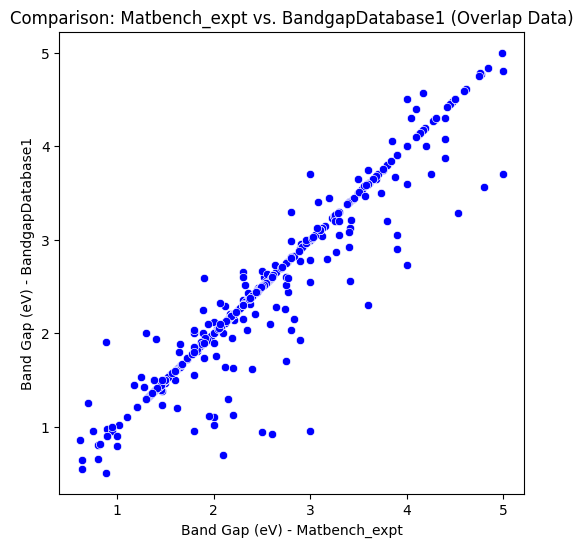

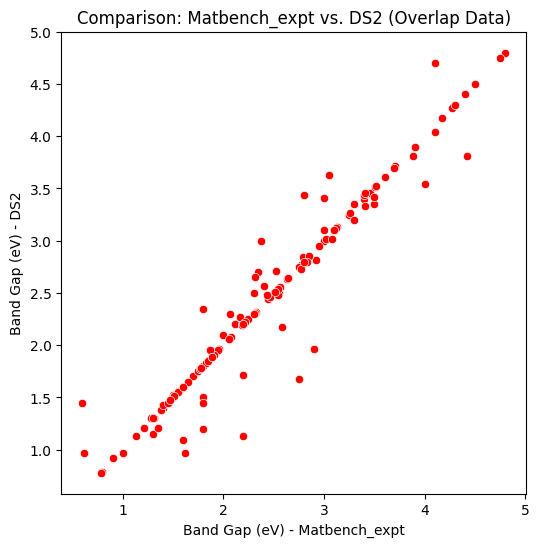

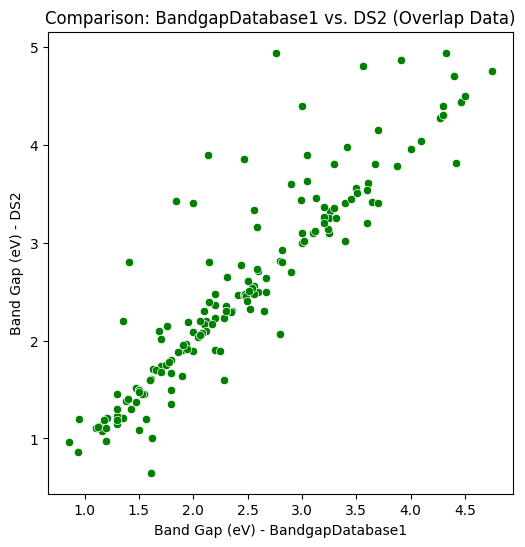

In [19]:
# Scatter Plot: Matbench_expt vs. BandgapDatabase1
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_overlap_matbench_bandgap["bg_expt"], y=df_overlap_matbench_bandgap["Value"], color="blue")
plt.title("Comparison: Matbench_expt vs. BandgapDatabase1 (Overlap Data)")
plt.xlabel("Band Gap (eV) - Matbench_expt")
plt.ylabel("Band Gap (eV) - BandgapDatabase1")
plt.show()

# Scatter Plot: Matbench_expt vs. DS2
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_overlap_matbench_ds2["bg_expt"], y=df_overlap_matbench_ds2["bg"], color="red")
plt.title("Comparison: Matbench_expt vs. DS2 (Overlap Data)")
plt.xlabel("Band Gap (eV) - Matbench_expt")
plt.ylabel("Band Gap (eV) - DS2")
plt.show()

# Scatter Plot: BandgapDatabase1 vs. DS2
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_overlap_bandgap_ds2["Value"], y=df_overlap_bandgap_ds2["bg"], color="green")
plt.title("Comparison: BandgapDatabase1 vs. DS2 (Overlap Data)")
plt.xlabel("Band Gap (eV) - BandgapDatabase1")
plt.ylabel("Band Gap (eV) - DS2")
plt.show()

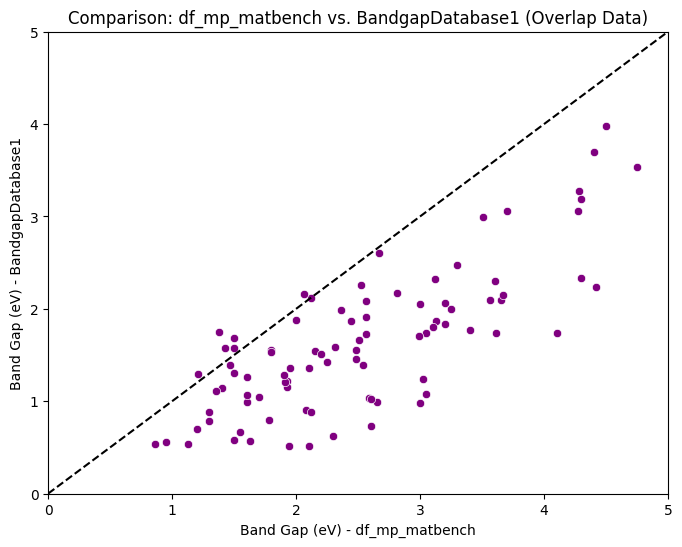

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

#overlap between df_mp_filtered and df_bandgap
df_overlap_mp_matbench_bandgap = df_mp_matbench[df_mp_matbench["mpids"].isin(overlap_all_three)].merge(
    df_bandgap[["mpids", "Value"]], on="mpids", how="left", suffixes=("_filtered", "_bandgap")
)
# comparison of band gap differences between df_mp_filtered and df_bandgap
# draw a line in the diagonal
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_overlap_mp_matbench_bandgap["Value"], y=df_overlap_mp_matbench_bandgap["band_gap"], color="purple")
plt.plot([0, 5], [0, 5], color='black', linestyle='--')  # Diagonal line
plt.title("Comparison: df_mp_matbench vs. BandgapDatabase1 (Overlap Data)")
plt.xlabel("Band Gap (eV) - df_mp_matbench")
plt.ylabel("Band Gap (eV) - BandgapDatabase1")
plt.xlim(0, 5)
plt.ylim(0, 5)
# plt.grid(True)
# save as pdf
plt.savefig('comparison_mp_filtered_bandgap.pdf')
plt.show()


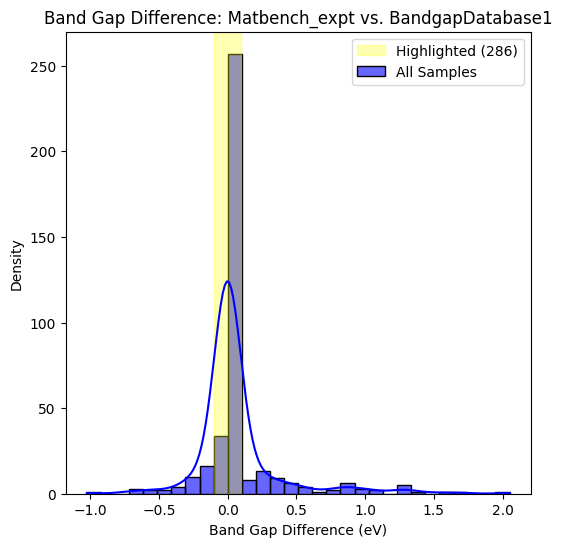

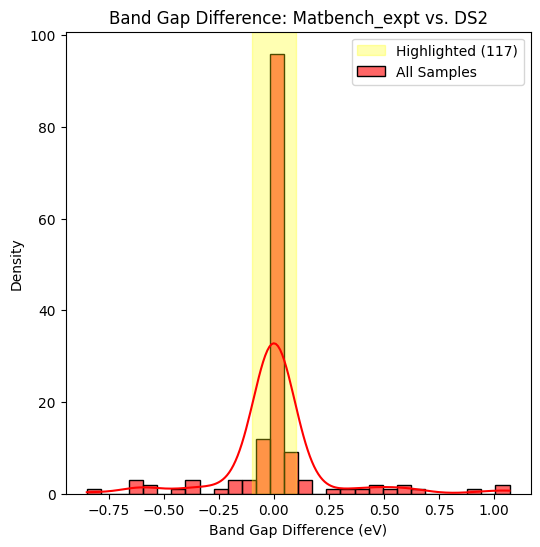

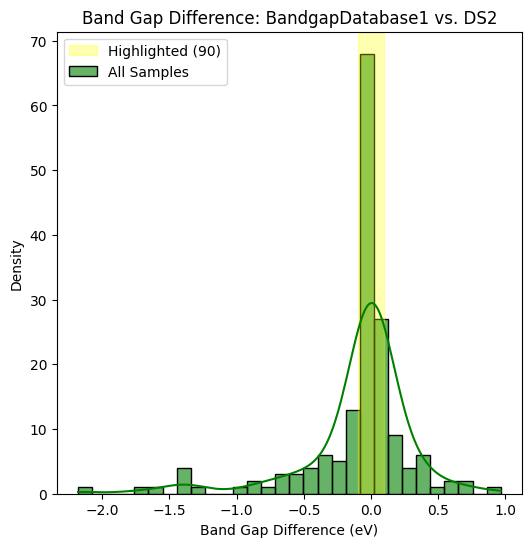

In [21]:
# # band gap difference for each dataset

# # Compute band gap differences
# df_overlap_matbench_bandgap["diff"] = df_overlap_matbench_bandgap["bg_expt"] - df_overlap_matbench_bandgap["Value"]
# df_overlap_matbench_ds2["diff"] = df_overlap_matbench_ds2["bg_expt"] - df_overlap_matbench_ds2["bg"]
# df_overlap_bandgap_ds2["diff"] = df_overlap_bandgap_ds2["Value"] - df_overlap_bandgap_ds2["bg"]

# # Plot band gap differences: Matbench_expt vs. BandgapDatabase1
# plt.figure(figsize=(6, 6))
# sns.histplot(df_overlap_matbench_bandgap["diff"], bins=30, kde=True, color="blue")
# plt.title("Band Gap Difference: Matbench_expt vs. BandgapDatabase1")
# plt.xlabel("Band Gap Difference (eV)")
# plt.ylabel("Density")
# plt.show()

# # Plot band gap differences: Matbench_expt vs. DS2
# plt.figure(figsize=(6, 6))
# sns.histplot(df_overlap_matbench_ds2["diff"], bins=30, kde=True, color="red")
# plt.title("Band Gap Difference: Matbench_expt vs. DS2")
# plt.xlabel("Band Gap Difference (eV)")
# plt.ylabel("Density")
# plt.show()

# # Plot band gap differences: BandgapDatabase1 vs. DS2
# plt.figure(figsize=(6, 6))
# sns.histplot(df_overlap_bandgap_ds2["diff"], bins=30, kde=True, color="green")
# plt.title("Band Gap Difference: BandgapDatabase1 vs. DS2")
# plt.xlabel("Band Gap Difference (eV)")
# plt.ylabel("Density")
# plt.show()

# plot of the band gap differences for datasets overlap, the highlighted samples are those with difference in range [-0.1, 0.1]

# Compute band gap differences
df_overlap_matbench_bandgap["diff"] = df_overlap_matbench_bandgap["bg_expt"] - df_overlap_matbench_bandgap["Value"]
df_overlap_matbench_ds2["diff"] = df_overlap_matbench_ds2["bg_expt"] - df_overlap_matbench_ds2["bg"]
df_overlap_bandgap_ds2["diff"] = df_overlap_bandgap_ds2["Value"] - df_overlap_bandgap_ds2["bg"]

# Filter samples with difference in range [-0.1, 0.1]
df_close_filtered_bandgap = df_overlap_matbench_bandgap[df_overlap_matbench_bandgap["diff"].between(-0.1, 0.1)]
df_close_filtered_ds2 = df_overlap_matbench_ds2[df_overlap_matbench_ds2["diff"].between(-0.1, 0.1)]
df_close_bandgap_ds2 = df_overlap_bandgap_ds2[df_overlap_bandgap_ds2["diff"].between(-0.1, 0.1)]

# Function to plot histogram and highlight samples with count label
def plot_difference(df, df_close, title, color):
    plt.figure(figsize=(6, 6))
    sns.histplot(df["diff"], bins=30, kde=True, color=color, alpha=0.6, label="All Samples")
    plt.axvspan(-0.1, 0.1, color="yellow", alpha=0.3, label=f"Highlighted ({len(df_close)})")
    plt.title(title)
    plt.xlabel("Band Gap Difference (eV)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot differences with highlights and labels
plot_difference(df_overlap_matbench_bandgap, df_close_filtered_bandgap, "Band Gap Difference: Matbench_expt vs. BandgapDatabase1", "blue")
plot_difference(df_overlap_matbench_ds2, df_close_filtered_ds2, "Band Gap Difference: Matbench_expt vs. DS2", "red")
plot_difference(df_overlap_bandgap_ds2, df_close_bandgap_ds2, "Band Gap Difference: BandgapDatabase1 vs. DS2", "green")


In [22]:
# Ensure necessary libraries are imported
import pandas as pd

# Reload data and define MPIDs based on the Venn diagram
mpids_matbench = set(df_matbench["mpids"])
mpids_bandgap = set(df_bandgap["mpids"])
mpids_ds2 = set(df_ds2["mpids"])

# Find overlap sets
overlap_matbench_bandgap = mpids_matbench & mpids_bandgap
overlap_matbench_ds2 = mpids_matbench & mpids_ds2
overlap_bandgap_ds2 = mpids_bandgap & mpids_ds2
overlap_all_three = mpids_matbench & mpids_bandgap & mpids_ds2  # MPIDs present in all three datasets

# Remove MPIDs that are in all three from individual overlap sets
overlap_matbench_bandgap -= overlap_all_three
overlap_matbench_ds2 -= overlap_all_three
overlap_bandgap_ds2 -= overlap_all_three

# find unique mpids in each DataFrame (mpids in one df but not the others)
unique_matbench = set(df_matbench["mpids"]) - (set(df_bandgap["mpids"]) | set(df_ds2["mpids"]))
unique_bandgap = set(df_bandgap["mpids"]) - (set(df_matbench["mpids"]) | set(df_ds2["mpids"]))
unique_ds2 = set(df_ds2["mpids"]) - (set(df_matbench["mpids"]) | set(df_bandgap["mpids"]))

# if data available in bandgap, choose bandgap, if available in ds2, choose ds2, if not available in both, choose matbench
df_overlap_matbench_bandgap = df_bandgap[df_bandgap["mpids"].isin(overlap_matbench_bandgap)][["mpids", "formula", "band_gap", "Value", "num_elements"]]
df_overlap_matbench_ds2 = df_ds2[df_ds2["mpids"].isin(overlap_matbench_ds2)][["mpids", "formula", "bg_mp", "bg", "num_elements"]]
df_overlap_bandgap_ds2 = df_bandgap[df_bandgap["mpids"].isin(overlap_bandgap_ds2)][["mpids", "formula", "band_gap", "Value", "num_elements"]]
df_overlap_all_three = df_bandgap[df_bandgap["mpids"].isin(overlap_all_three)][["mpids", "formula", "band_gap", "Value", "num_elements"]]  # Assigning bandgap from df_bandgap
df_unique_bandgap = df_bandgap[df_bandgap["mpids"].isin(unique_bandgap)][["mpids", "formula", "band_gap", "Value", "num_elements"]]
df_unique_matbench = df_matbench[df_matbench["mpids"].isin(unique_matbench)][["mpids", "formula", "band_gap", "bg_expt", "num_elements"]]
df_unique_ds2 = df_ds2[df_ds2["mpids"].isin(unique_ds2)][["mpids", "formula", "bg_mp", "bg", "num_elements"]]

# rename columns for clarity, band_gap to bg_mp, value and bg to bg_exp
df_overlap_matbench_bandgap.rename(columns={"band_gap": "bg_mp", "Value": "bg_exp"}, inplace=True)
df_overlap_matbench_ds2.rename(columns={"bg": "bg_exp"}, inplace=True)
df_overlap_bandgap_ds2.rename(columns={"band_gap": "bg_mp", "Value": "bg_exp"}, inplace=True)
df_overlap_all_three.rename(columns={"band_gap": "bg_mp", "Value": "bg_exp"}, inplace=True)  
df_unique_bandgap.rename(columns={"band_gap": "bg_mp", "Value": "bg_exp"}, inplace=True)
df_unique_matbench.rename(columns={"band_gap": "bg_mp", "bg_expt": "bg_exp"}, inplace=True)
df_unique_ds2.rename(columns={"bg": "bg_exp"}, inplace=True)

# Add source column
df_overlap_matbench_bandgap["source"] = "BandgapDatabase1"
df_overlap_matbench_ds2["source"] = "DS2"  # Assigning source for DS2
df_overlap_bandgap_ds2["source"] = "BandgapDatabase1"
df_overlap_all_three["source"] = "BandgapDatabase1"  # Assign a single source for consistency
df_unique_bandgap["source"] = "BandgapDatabase1"
df_unique_matbench["source"] = "Matbench_expt"
df_unique_ds2["source"] = "DS2"

# Concatenate overlap data (ensuring three-way overlaps appear only once)
df_combined_overlap = pd.concat([
    df_overlap_matbench_bandgap,
    df_overlap_matbench_ds2,
    df_overlap_bandgap_ds2,
    df_overlap_all_three
], ignore_index=True)

# Merge with unique data
df_combined = pd.concat([df_combined_overlap, df_unique_matbench, df_unique_bandgap, df_unique_ds2], ignore_index=True)

# Debugging: Check why NaN values exist
nan_rows = df_combined[df_combined["bg_exp"].isna()]
if not nan_rows.empty:
    missing_mpids = nan_rows["mpids"]
    df_bandgap_missing = df_bandgap[df_bandgap["mpids"].isin(missing_mpids)]

# save df_combined to csv
df_combined.to_csv('data/joint_dataset/combined_bandgap_data.csv', index=False)

df_combined

,mpids,formula,bg_mp,bg_exp,num_elements,source
0,mp-9770,Ag8GeS6,0.6102,1.450,3,BandgapDatabase1
1,mp-29678,AgBiS2,0.5212,0.980,3,BandgapDatabase1
2,mp-1195243,AgP15,1.2132,1.380,2,BandgapDatabase1
3,mp-1193499,AgPd(IO3)3,1.4039,1.500,4,BandgapDatabase1
4,mp-1582,As2O3,4.0339,4.500,2,BandgapDatabase1
...,...,...,...,...,...,...
1700,mp-22858,TlI,2.3198,2.867,2,DS2
1701,mp-558747,TlTiPS5,1.1772,1.300,4,DS2
1702,mp-4842,ZnAl2S4,2.6027,3.500,3,DS2
1703,mp-1392,ZnP2,0.7480,1.420,2,DS2


In [23]:
df_ds2

,mpids,formula,bg_mp,bg,num_elements
0,mp-390,TiO2,2.0625,3.20,2
1,mp-2657,TiO2,1.7719,3.02,2
2,mp-32777,WO3,1.2338,2.76,2
3,mp-619461,WO3,1.3712,2.73,2
6,mp-19009,NiO,2.4141,3.54,2
...,...,...,...,...,...
501,mp-2979,ZnGeN2,1.6966,3.36,3
502,mp-1392,ZnP2,0.7480,1.42,2
503,mp-560588,ZnS,2.0776,3.91,2
504,mp-13334,ZnSnO3,1.0810,3.90,3


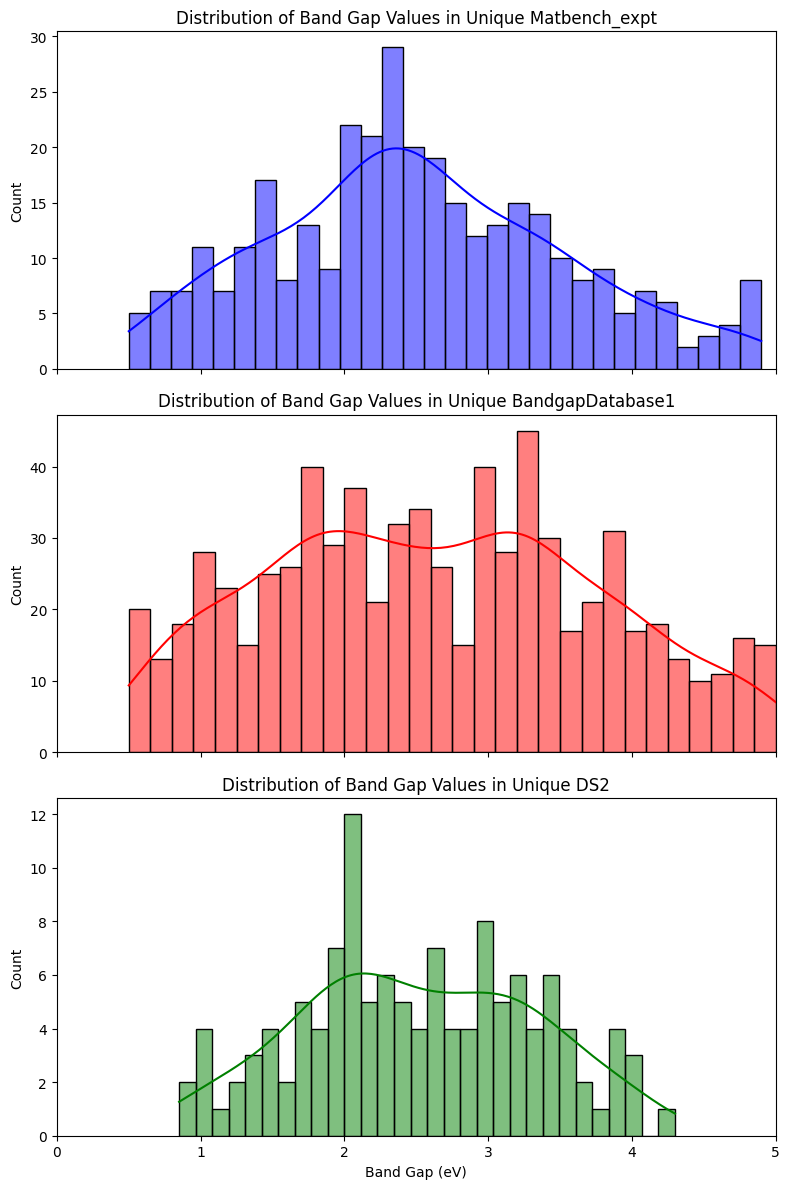

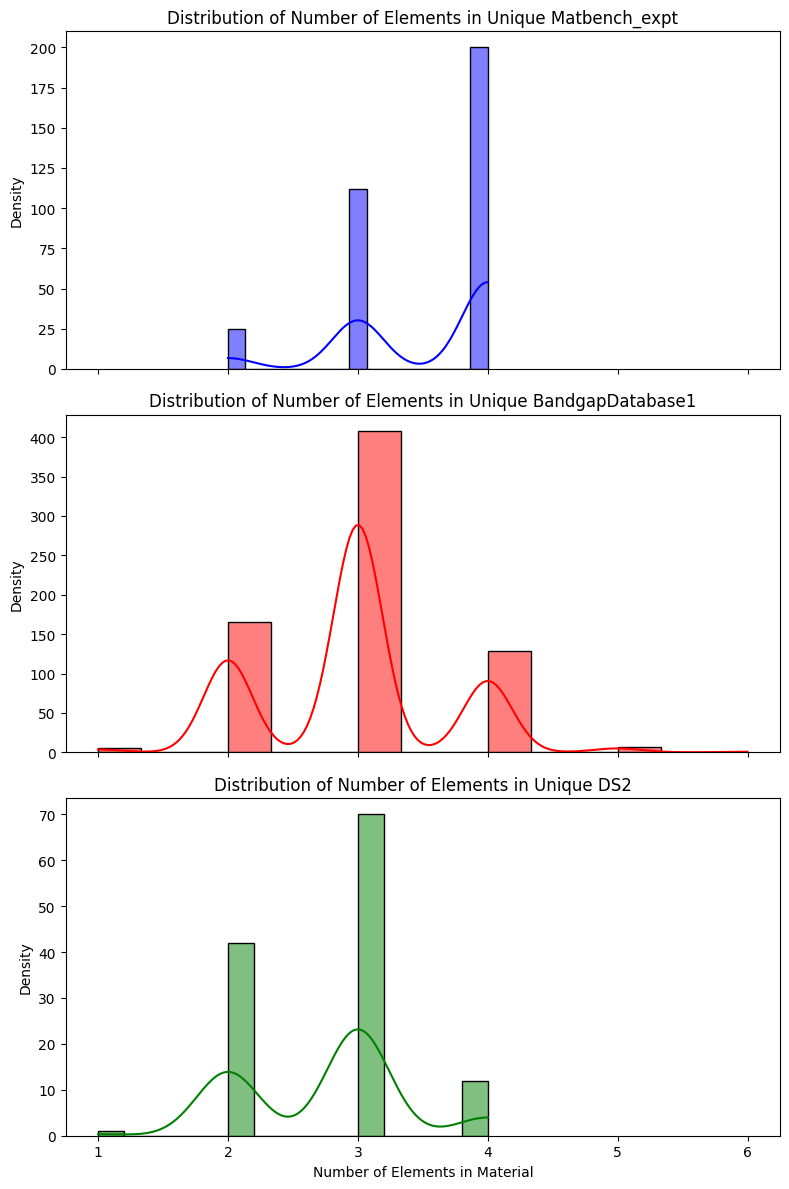

In [24]:
# analyze the unique datasets
# plot the band gap distribution for each dataset
import seaborn as sns
import matplotlib.pyplot as plt
# Set fixed x and y axis range
x_range = (0, 5)  # Band gap range from 0 to 5 eV
y_range = (0, None)  # Let y-axis adjust based on data density  
# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
# Plot distribution for df_unique_matbench
sns.histplot(df_unique_matbench["bg_exp"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Band Gap Values in Unique Matbench_expt")
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)
axes[0].set_xlabel("Band Gap (eV)") 
# Plot distribution for df_unique_bandgap
sns.histplot(df_unique_bandgap["bg_exp"], bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Band Gap Values in Unique BandgapDatabase1")
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)
axes[1].set_xlabel("Band Gap (eV)")
# Plot distribution for df_unique_ds2
sns.histplot(df_unique_ds2["bg_exp"], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribution of Band Gap Values in Unique DS2")
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)
axes[2].set_xlabel("Band Gap (eV)")
# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# create the distribution of number of elements in each dataset
# Count the number of elements for each dataset
df_unique_matbench["num_elements"] = df_unique_matbench["formula"].apply(count_elements)
df_unique_bandgap["num_elements"] = df_unique_bandgap["formula"].apply(count_elements)
df_unique_ds2["num_elements"] = df_unique_ds2["formula"].apply(count_elements)  
# Create separate subplots for each dataset
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
# Plot distribution for df_unique_matbench
sns.histplot(df_unique_matbench["num_elements"], bins=15, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Number of Elements in Unique Matbench_expt")
axes[0].set_ylabel("Density")
# Plot distribution for df_unique_bandgap
sns.histplot(df_unique_bandgap["num_elements"], bins=15, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Number of Elements in Unique BandgapDatabase1")
axes[1].set_ylabel("Density")
# Plot distribution for df_unique_ds2
sns.histplot(df_unique_ds2["num_elements"], bins=15, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribution of Number of Elements in Unique DS2")
axes[2].set_xlabel("Number of Elements in Material")
axes[2].set_ylabel("Density")   
# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [25]:
import re
def categorize_compound(formula):
    """
    Categorizes a compound formula into predefined categories.

    Args:
        formula (str): The chemical formula to categorize.

    Returns:
        str: The category of the compound.
    """
    # Define regular expressions for each category, ordered by priority
    categories = {
        # "Double anions": r"(?:(?:O|C(?![a-z])|H(?![a-z])|N(?![a-z])|S(?![a-z])|Se|Te|F(?![a-z])|Cl|Br|I|P(?![a-z])|As|Sb|Si|CO3|SO4|NO3|PO4|CN|SCN|ClO3)\d?){2}",
        "Arsenides": r"As",
        "Antimonides": r"Sb",
        "Silicides": r"Si",
        # "Halides": r"F|Cl|Br|I",
        "Halides": r"F(?![a-z])|Cl(?![a-z])|Br(?![a-z])|I(?![a-z])",
        "Chalcogenides": r"S(?![a-z])|Se(?![a-z])|Te(?![a-z])",
        "Oxides": r"O(?![A-Za-z])",
        "Nitrides": r"N(?![A-Za-z])",
        "Phosphides": r"P(?![A-Za-z])",
        
        "Carbides": r"C(?![A-Za-z])",
        "Hydrides": r"H(?![A-Za-z])",
        "Others": None  # Default category
    }
    matched_categories = []

    # # Check for double anions first
    # double_anion_pattern = r"(?:O|C|H)\d"
    # if re.search(double_anion_pattern, formula):
    #     return "Double anions (manual check)"

    # Check each category in priority order
    for category, pattern in categories.items():
        if pattern and re.search(pattern, formula):
            matched_categories.append(category)

    # If multiple categories match, prioritize based on the first match
    if matched_categories:
        return matched_categories[0], len(matched_categories)  # Return the highest-priority match

    # If no category matched, return "Others"
    return "Others", 0

# Apply the categorization function for the unique datasets
df_unique_matbench["category"], df_unique_matbench["num_categories"] = zip(*df_unique_matbench["formula"].apply(categorize_compound))
df_unique_bandgap["category"], df_unique_bandgap["num_categories"] = zip(*df_unique_bandgap["formula"].apply(categorize_compound))
df_unique_ds2["category"], df_unique_ds2["num_categories"] = zip(*df_unique_ds2["formula"].apply(categorize_compound))


/tmp/ipykernel_2531845/2815829324.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_unique_matbench, x="category", order=category_order, ax=axes[0], palette="Blues")
/tmp/ipykernel_2531845/2815829324.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_unique_bandgap, x="category", order=category_order, ax=axes[1], palette="Reds")
/tmp/ipykernel_2531845/2815829324.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_unique_ds2, x="category", order=category_order, ax=axes[2], palette="Greens")


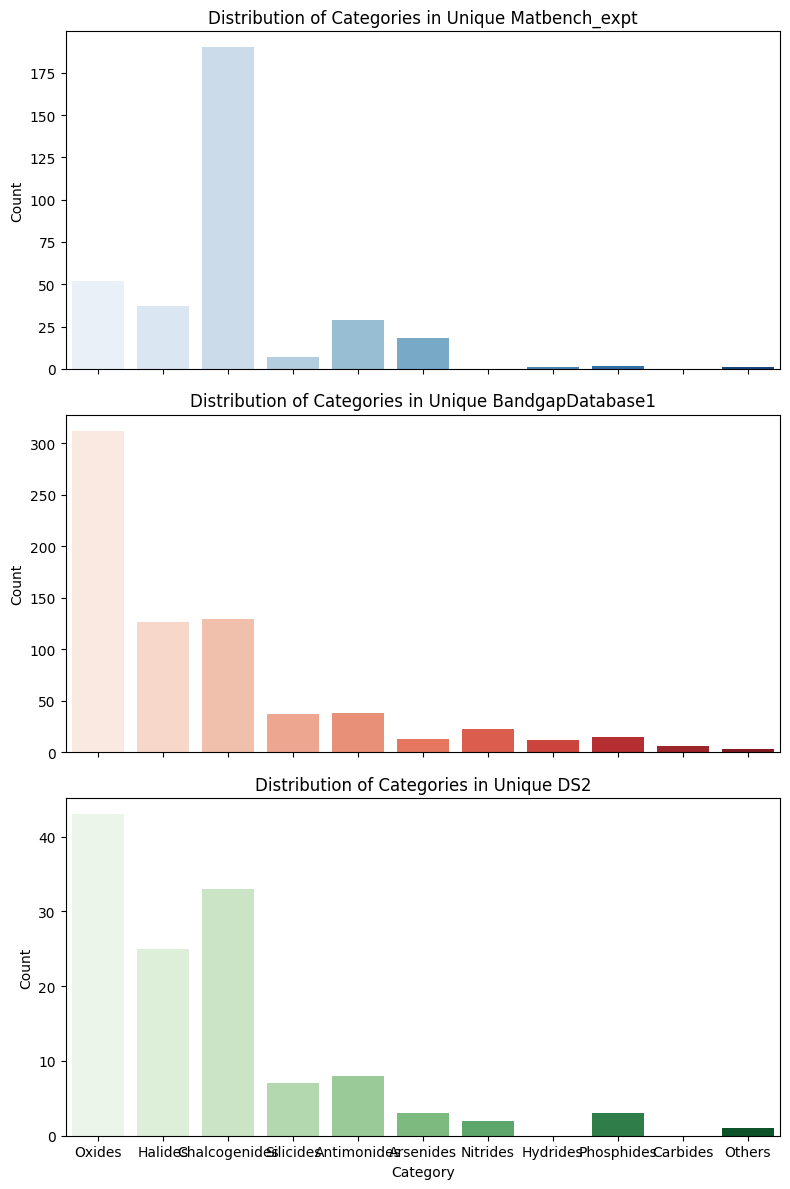

In [26]:
# plot the distribution of categories for each dataset
# x axis is category, in the order of: oxides, halides, chalcogenides, silicides, antimonides, arsenides, nitrides, hydrides, phosphides, others, carbides
category_order = [
    "Oxides", "Halides", "Chalcogenides", "Silicides",
    "Antimonides", "Arsenides", "Nitrides", "Hydrides",
    "Phosphides", "Carbides", "Others"
]   
# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)    
# Plot distribution for df_unique_matbench
sns.countplot(data=df_unique_matbench, x="category", order=category_order, ax=axes[0], palette="Blues")
axes[0].set_title("Distribution of Categories in Unique Matbench_expt")
axes[0].set_ylabel("Count") 
# Plot distribution for df_unique_bandgap
sns.countplot(data=df_unique_bandgap, x="category", order=category_order, ax=axes[1], palette="Reds")
axes[1].set_title("Distribution of Categories in Unique BandgapDatabase1")
axes[1].set_ylabel("Count")
# Plot distribution for df_unique_ds2
sns.countplot(data=df_unique_ds2, x="category", order=category_order, ax=axes[2], palette="Greens")
axes[2].set_title("Distribution of Categories in Unique DS2")
axes[2].set_xlabel("Category")
axes[2].set_ylabel("Count")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [27]:
# # split the data into training and holdout sets
# # Ensure data is loaded before processing
# if "df_combined" in locals():
#     # Split the dataset
#     df_holdout = df_combined[df_combined["source"] == "Matbench_expt"]
#     df_train = df_combined[df_combined["source"] != "Matbench_expt"]

# else:
#     print("Dataset not found. Please reload df_combined.")


In [28]:
# # Ensure data is loaded before processing
# if "df_train" in locals() and "df_holdout" in locals():
#     # Convert df_train to JSON format including source
#     df_train_json = df_train.set_index("mpids")[[ "bg_mp", "bg_exp", "source"]].to_dict(orient="index")

#     # Convert df_holdout to JSON format including source
#     df_holdout_json = df_holdout.set_index("mpids")[[ "bg_mp", "bg_exp", "source"]].to_dict(orient="index")

#     # Save JSON files
#     import json

#     train_json_path = "./data/joint_dataset/train_data_raw.json"
#     holdout_json_path = "./data/joint_dataset/test_data_raw.json"

#     # create the directory
#     import os
#     os.makedirs(os.path.dirname(train_json_path), exist_ok=True)
#     os.makedirs(os.path.dirname(holdout_json_path), exist_ok=True)

#     with open(train_json_path, "w") as f:
#         json.dump(df_train_json, f, indent=2)

#     with open(holdout_json_path, "w") as f:
#         json.dump(df_holdout_json, f, indent=2)

#     # Provide download links
#     train_json_path, holdout_json_path
# else:
#     print("Datasets not found. Please reload df_train and df_holdout.")


In [29]:
# # make the bg_exp values called bg in the train and holdout sets
# df_train_processed = df_train.rename(columns={"bg_exp": "bg"})
# df_holdout_processed = df_holdout.rename(columns={"bg_exp": "bg"})
# # Save the modified DataFrames back to JSON format
# train_json_path = "./data/joint_dataset/train_data.json"
# holdout_json_path = "./data/joint_dataset/test_data.json"
# # create the directory
# import os
# os.makedirs(os.path.dirname(train_json_path), exist_ok=True)
# os.makedirs(os.path.dirname(holdout_json_path), exist_ok=True)      
# df_train_processed.set_index("mpids")[["bg"]].to_json(train_json_path, orient="index", indent=2)
# df_holdout_processed.set_index("mpids")[[ "bg"]].to_json(holdout_json_path, orient="index", indent=2) 



In [30]:
# # make dataset for ablation study: train and test on matbench_expt only
# # split the matbench_expt into training and holdout sets, use 15% of the df_matbench for holdout set
# from sklearn.model_selection import train_test_split
# # Ensure df_matbench is defined
# if "df_matbench" in locals():
#     # Split df_matbench into training and holdout sets
#     df_train_matbench, df_holdout_matbench = train_test_split(
#         df_matbench, test_size=0.15, random_state=2015
#     )

#     # Save the training and holdout sets to JSON format
#     train_json_path = "./data/ablation_study_matbench/train_data.json"
#     holdout_json_path = "./data/ablation_study_matbench/test_data.json"

#     # create the directory
#     import os
#     os.makedirs(os.path.dirname(train_json_path), exist_ok=True)
#     os.makedirs(os.path.dirname(holdout_json_path), exist_ok=True)

#     df_train_matbench.set_index("mpids")[["bg_expt"]].rename(columns={"bg_expt": "bg"}).to_json(train_json_path, orient="index", indent=2)
#     df_holdout_matbench.set_index("mpids")[["bg_expt"]].rename(columns={"bg_expt": "bg"}).to_json(holdout_json_path, orient="index", indent=2)
#     # Provide download links
#     train_json_path, holdout_json_path
# else:
#     print("Dataset df_matbench not found. Please load it before splitting.")

In [31]:
# # make distribution of band gap values for the ablation study
# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set fixed x and y axis range  
# x_range = (0, 5)  # Band gap range from 0 to 5 eV
# y_range = (0, None)  # Let y-axis adjust based on data density
# # Create figure with subplots
# fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# # Plot distribution for df_train_matbench
# sns.histplot(df_train_matbench["bg_expt"], bins=30, kde=True, ax=axes[0], color="blue")
# axes[0].set_title("Distribution of Band Gap Values in Train Set (Matbench_expt)")
# axes[0].set_xlim(x_range)
# axes[0].set_ylim(y_range)
# axes[0].set_ylabel("Density")
# # Plot distribution for df_holdout_matbench
# sns.histplot(df_holdout_matbench["bg_expt"], bins=30, kde=True, ax=axes[1], color="red")
# axes[1].set_title("Distribution of Band Gap Values in Holdout Set (Matbench_expt)")
# axes[1].set_xlim(x_range)
# axes[1].set_ylim(y_range)
# axes[1].set_xlabel("Band Gap (eV)")
# axes[1].set_ylabel("Density")   
# # Adjust layout and show the plots
# plt.tight_layout()
# plt.show()

# # make distribution of number of elements in the ablation study datasets
# # Function to count the number of elements in a formula
# def count_elements(formula):
#     return sum(1 for char in formula if char.isupper())  # Count uppercase letters  
# # Apply the function to count elements for each dataset
# df_train_matbench["num_elements"] = df_train_matbench["formula"].apply(count_elements)
# df_holdout_matbench["num_elements"] = df_holdout_matbench["formula"].apply(count_elements)  
# # Create separate subplots for each dataset
# fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# # Plot distribution for df_train_matbench
# sns.histplot(df_train_matbench["num_elements"], bins=15, kde=True, ax=axes[0], color="blue")
# axes[0].set_title("Distribution of Number of Elements in Train Set (Matbench_expt)")
# axes[0].set_ylabel("Density")   
# # Plot distribution for df_holdout_matbench
# sns.histplot(df_holdout_matbench["num_elements"], bins=15, kde=True,

#     ax=axes[1], color="red")        
# axes[1].set_title("Distribution of Number of Elements in Holdout Set (Matbench_expt)")
# axes[1].set_xlabel("Number of Elements in Material")
# axes[1].set_ylabel("Density")
# # Adjust layout and show the plots
# plt.tight_layout()
# plt.show()

# # make distribution of categories in the ablation study datasets
# # Apply the categorization function for the ablation study datasets
# df_train_matbench["category"], df_train_matbench["num_categories"] = zip(*df_train_matbench["formula"].apply(categorize_compound))
# df_holdout_matbench["category"], df_holdout_matbench["num_categories"] = zip(*df_holdout_matbench["formula"].apply(categorize_compound))
# # plot the distribution of categories for each dataset
# # x axis is category, in the order of: oxides, halides, chalcogenides, silicides, antimonides, arsenides, nitrides, hydrides, phosphides, others, carbides
# category_order = [
#     "Oxides", "Halides", "Chalcogenides", "Silicides",
#     "Antimonides", "Arsenides", "Nitrides", "Hydrides",
#     "Phosphides", "Carbides", "Others"
# ]
# # Create a figure with subplots
# fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)    
# # Plot distribution for df_train_matbench
# sns.countplot(data=df_train_matbench, x="category", order=category_order, ax=axes[0], palette="Blues")
# axes[0].set_title("Distribution of Categories in Train Set (Matbench_expt)")
# axes[0].set_ylabel("Count") 
# # Plot distribution for df_holdout_matbench
# sns.countplot(data=df_holdout_matbench, x="category", order=category_order, ax=axes[1], palette="Reds")
# axes[1].set_title("Distribution of Categories in Holdout Set (Matbench_expt)")
# axes[1].set_xlabel("Category")
# axes[1].set_ylabel("Count") 
# # Adjust layout and show the plots
# plt.tight_layout()
# plt.show()

In [32]:
# categorize the combined dataset
df_combined["category"], df_combined["num_categories"] = zip(*df_combined["formula"].apply(categorize_compound))
df_combined

,mpids,formula,bg_mp,bg_exp,num_elements,source,category,num_categories
0,mp-9770,Ag8GeS6,0.6102,1.450,3,BandgapDatabase1,Chalcogenides,1
1,mp-29678,AgBiS2,0.5212,0.980,3,BandgapDatabase1,Chalcogenides,1
2,mp-1195243,AgP15,1.2132,1.380,2,BandgapDatabase1,Phosphides,1
3,mp-1193499,AgPd(IO3)3,1.4039,1.500,4,BandgapDatabase1,Halides,2
4,mp-1582,As2O3,4.0339,4.500,2,BandgapDatabase1,Arsenides,2
...,...,...,...,...,...,...,...,...
1700,mp-22858,TlI,2.3198,2.867,2,DS2,Halides,1
1701,mp-558747,TlTiPS5,1.1772,1.300,4,DS2,Chalcogenides,1
1702,mp-4842,ZnAl2S4,2.6027,3.500,3,DS2,Chalcogenides,1
1703,mp-1392,ZnP2,0.7480,1.420,2,DS2,Phosphides,1


In [33]:
# count of the num_categories in combined dataset
df_combined["num_categories"].value_counts().sort_index()


num_categories
0       7
1    1254
2     406
3      38
Name: count, dtype: int64

/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 3 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 12 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountere

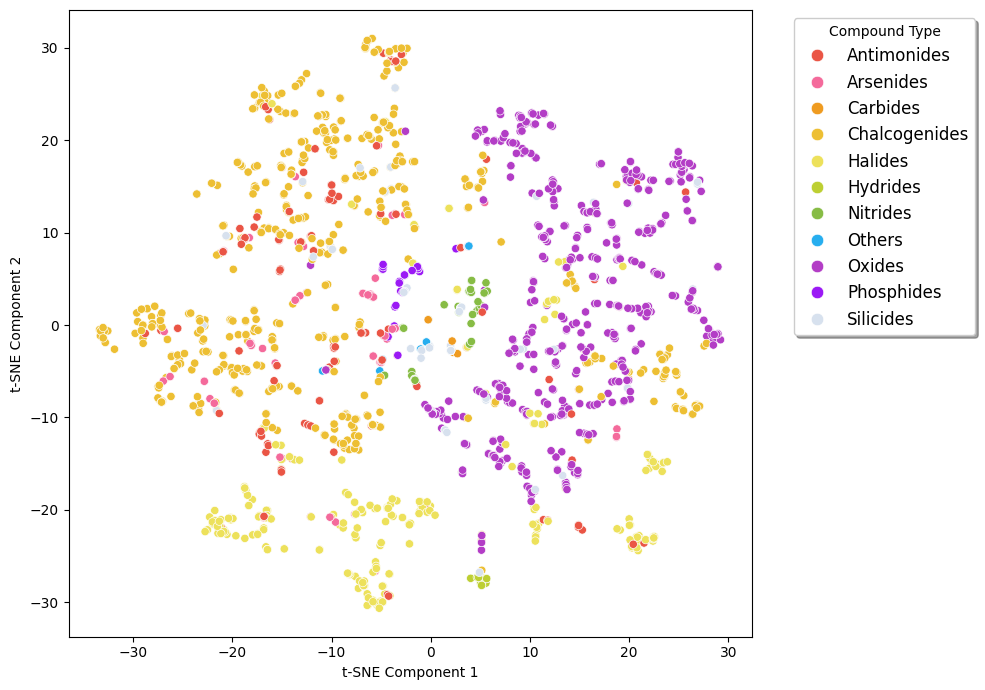

In [34]:
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from data_process.cifdata import CIFData
from data_process.dataloader import extract_features


x_dataset=CIFData(mpids_bg=df_combined[['mpids', 'bg_exp']],cif_folder='cif_file', init_file='encoding/atom_init.json',
                                max_nbrs=14, radius=7, randomize=False)
X, y = extract_features(x_dataset)

# Convert compound_types to a NumPy array for proper indexing
compound_types = df_combined["category"].to_numpy()

# Generate 10 colors from the "Set2" palette
colors = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6", "#9b19f5","#d7e1ee"]
# Define a fixed color palette for each compound type (sorted order)
unique_compounds = sorted(list(np.unique(compound_types)))  # Convert NumPy array to a Python list
fixed_palette = {compound: color for compound, color in zip(unique_compounds, colors)}



# # Step 1: Reduce dimensionality with PCA for faster t-SNE
# pca = PCA(n_components=10, random_state=42)  # Reduce to 10D
# X_pca = pca.fit_transform(X)

# # Step 2: Sample a subset of data for faster computation
# subset_size = min(500, X_pca.shape[0])  # Use 500 samples max
# subset_indices = np.random.choice(X_pca.shape[0], subset_size, replace=False)
# X_subset = X_pca[subset_indices]
# compound_types_subset = compound_types_array[subset_indices]  # Fixed indexing

# Step 3: Run t-SNE
tsne = TSNE(n_components=2, perplexity=15, n_iter=400, method='barnes_hut', random_state=42)
X_tsne = tsne.fit_transform(X)

# Step 5: Plot with fixed colors
plt.figure(figsize=(10, 7))
ax=sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=compound_types,
    palette=fixed_palette,  # Use the predefined color mapping
    legend='full'
)

# Manually fix the order of legend categories
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: unique_compounds.index(x[1]))  # Sort by predefined order
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Improve legend visibility with fixed order
plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=1.5, frameon=True, shadow=True, title="Compound Type")


plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# plt.title("t-SNE Visualization of Encoded Features (Fixed Colors)")

plt.tight_layout()

# save plot as pdf
plt.savefig('tSNE_plot.pdf', bbox_inches='tight')

plt.show()

In [35]:
import os
import json

# Create a directory to save the JSON files
output_dir = "./data/split_by_category"
os.makedirs(output_dir, exist_ok=True)

# remove df_combined rows with category "Others"
df_combined_temp = df_combined[df_combined["category"] != "Others"]
# remove df_combined rows with multiple categories (num_categories > 1)
df_combined_temp = df_combined_temp[df_combined_temp["num_categories"] == 1]

# Group the data by category and save each group as a separate JSON file
for category, group in df_combined_temp.groupby("category"):
    # Keep only the required columns and rename bg_exp to bg
    group = group[["mpids", "bg_exp"]].rename(columns={"bg_exp": "bg"}).set_index("mpids")
    
    # Convert the group to a dictionary
    group_dict = group.to_dict(orient="index")
    
    # Define the output file paths
    test_file = os.path.join(output_dir, f"{category.replace(' ', '_')}.test.json")
    train_file = os.path.join(output_dir, f"{category.replace(' ', '_')}.train.json")
    
    # Save the test file (data for the current category)
    with open(test_file, "w") as f:
        json.dump(group_dict, f, indent=2)
    
    # Save the train file (data for the rest of the categories)
    train_group = df_combined_temp[~df_combined_temp["category"].eq(category)]
    train_group = train_group[["mpids", "bg_exp"]].rename(columns={"bg_exp": "bg"}).set_index("mpids")
    train_group_dict = train_group.to_dict(orient="index")
    
    with open(train_file, "w") as f:

        json.dump(train_group_dict, f, indent=2)

# number of samples in df_combined_temp
len(df_combined_temp)

1254

In [49]:
# df_combined
# calculate the mae, mrae and r2 of the band gap values between bg_mp and bg_exp in df_combined
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(df_combined["bg_exp"], df_combined["bg_mp"])
mrae = (abs(df_combined["bg_exp"] - df_combined["bg_mp"]) / df_combined["bg_exp"]).mean()
r2 = r2_score(df_combined["bg_exp"], df_combined["bg_mp"])
mae, mrae, r2   

(0.7503187683284459, 0.3397527393903467, 0.11621722445730387)

In [37]:
# # =============================================
# # Stratified train/test split + JSON saving
# # =============================================

# import os
# import json
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # -----------------------------
# # Configuration
# # -----------------------------
# output_dir = "data/stratified_split"
# os.makedirs(output_dir, exist_ok=True)

# # -----------------------------
# # Sanity check: ensure df_combined exists
# # -----------------------------
# if "df_combined" not in locals():
#     raise ValueError("❌ The dataframe 'df_combined' is not defined in this notebook.")

# # -----------------------------
# # Ensure the dataset has the required columns
# # -----------------------------
# required_cols = {"mpids", "bg_exp"}
# missing_cols = required_cols - set(df_combined.columns)
# if missing_cols:
#     raise ValueError(f"❌ Missing required columns: {missing_cols}")

# if "category" not in df_combined.columns:
#     raise ValueError("❌ The dataset does not contain a 'category' column required for stratified split.")

# # -----------------------------
# # Perform stratified split
# # -----------------------------
# train_set, test_set = train_test_split(
#     df_combined,
#     test_size=0.1,  # 10% for test
#     stratify=df_combined["category"],  # maintain category distribution
#     random_state=42
# )

# # -----------------------------
# # Display category distributions
# # -----------------------------
# print("✅ Training set distribution:")
# print(train_set["category"].value_counts())
# print("\n✅ Test set distribution:")
# print(test_set["category"].value_counts())

# # -----------------------------
# # Save JSON files (with mpid as key and bg_exp as value)
# # -----------------------------
# train_file = os.path.join(output_dir, "stratified_train.json")
# test_file = os.path.join(output_dir, "stratified_test.json")

# # Save the training set
# train_dict = train_set.set_index("mpids")[["bg_exp"]].rename(columns={"bg_exp": "bg"}).to_dict(orient="index")
# with open(train_file, "w") as f:
#     json.dump(train_dict, f, indent=2)

# # Save the test set
# test_dict = test_set.set_index("mpids")[["bg_exp"]].rename(columns={"bg_exp": "bg"}).to_dict(orient="index")
# with open(test_file, "w") as f:
#     json.dump(test_dict, f, indent=2)

# # -----------------------------
# # Verify saved files
# # -----------------------------
# train_count, test_count = len(train_dict), len(test_dict)
# print(f"\n✅ Saved train/test splits:")
# print(f"  Train: {train_count} samples → {train_file}")
# print(f"  Test:  {test_count} samples → {test_file}")

# # optional: quick check that they sum to full dataset
# print(f"\nTotal dataset size check: {len(df_combined)} = {train_count} (train) + {test_count} (test)")


In [38]:
# check the compound names in stratified test set
import json
with open('data/stratified_split/stratified_test.json', 'r') as f:
    stratified_test_data = json.load(f)
stratified_test_mpids = list(stratified_test_data.keys())
df_stratified_test = df_combined[df_combined['mpids'].isin(stratified_test_mpids)]
df_stratified_test[['mpids', 'formula', 'category']]
# print out the formulas and mpids in txt file
with open('data/stratified_split/stratified_test_formulas.txt', 'w') as f:
    for index, row in df_stratified_test[['mpids', 'formula', 'category']].iterrows():
        f.write(f"{row['mpids']}\t{row['formula']}\t{row['category']}\n")

In [39]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------------
# Configuration
# -----------------------------
train_json = "data/stratified_split/stratified_train.json"
output_json = "data/stratified_split/stratified_train_50.json"
random_state = 42

# -----------------------------
# Sanity check
# -----------------------------
if "df_combined" not in locals():
    raise ValueError("❌ df_combined is not defined.")

# -----------------------------
# Load stratified train json
# -----------------------------
with open(train_json, "r") as f:
    train_dict = json.load(f)

df_train = (
    pd.DataFrame.from_dict(train_dict, orient="index")
      .reset_index()
      .rename(columns={"index": "mpids", "bg": "bg_exp"})
)

# -----------------------------
# Attach category from df_combined
# -----------------------------
df_train = df_train.merge(
    df_combined[["mpids", "category"]],
    on="mpids",
    how="left"
)

if df_train["category"].isna().any():
    raise ValueError("❌ Some mpids are missing category in df_combined.")

# -----------------------------
# Stratified 50% split
# -----------------------------
train_50, _ = train_test_split(
    df_train,
    test_size=0.50,
    stratify=df_train["category"],
    random_state=random_state
)

# -----------------------------
# Save json
# -----------------------------
train50_dict = (
    train_50.set_index("mpids")[["bg_exp"]]
            .rename(columns={"bg_exp": "bg"})
            .to_dict(orient="index")
)

os.makedirs(os.path.dirname(output_json), exist_ok=True)
with open(output_json, "w") as f:
    json.dump(train50_dict, f, indent=2)

print(f"✅ Saved 50% stratified train set: {len(train50_dict)} samples")

✅ Saved 50% stratified train set: 767 samples


In [40]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------------
# Configuration
# -----------------------------
train_json = "data/stratified_split/stratified_train.json"
output_json = "data/stratified_split/stratified_train_25.json"
random_state = 42

# -----------------------------
# Sanity check
# -----------------------------
if "df_combined" not in locals():
    raise ValueError("❌ df_combined is not defined.")

# -----------------------------
# Load stratified train json
# -----------------------------
with open(train_json, "r") as f:
    train_dict = json.load(f)

df_train = (
    pd.DataFrame.from_dict(train_dict, orient="index")
      .reset_index()
      .rename(columns={"index": "mpids", "bg": "bg_exp"})
)

# -----------------------------
# Attach category from df_combined
# -----------------------------
df_train = df_train.merge(
    df_combined[["mpids", "category"]],
    on="mpids",
    how="left"
)

if df_train["category"].isna().any():
    raise ValueError("❌ Some mpids are missing category in df_combined.")

# -----------------------------
# Stratified 25% split
# -----------------------------
train_25, _ = train_test_split(
    df_train,
    test_size=0.75,
    stratify=df_train["category"],
    random_state=random_state
)

# -----------------------------
# Save json
# -----------------------------
train25_dict = (
    train_25.set_index("mpids")[["bg_exp"]]
            .rename(columns={"bg_exp": "bg"})
            .to_dict(orient="index")
)

os.makedirs(os.path.dirname(output_json), exist_ok=True)
with open(output_json, "w") as f:
    json.dump(train25_dict, f, indent=2)

print(f"✅ Saved 25% stratified train set: {len(train25_dict)} samples")


✅ Saved 25% stratified train set: 383 samples


In [41]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------------
# Configuration
# -----------------------------
train_json = "data/stratified_split/stratified_train.json"
output_json = "data/stratified_split/stratified_train_10.json"
random_state = 42

# -----------------------------
# Sanity check
# -----------------------------
if "df_combined" not in locals():
    raise ValueError("❌ df_combined is not defined.")

# -----------------------------
# Load stratified train json
# -----------------------------
with open(train_json, "r") as f:
    train_dict = json.load(f)

df_train = (
    pd.DataFrame.from_dict(train_dict, orient="index")
      .reset_index()
      .rename(columns={"index": "mpids", "bg": "bg_exp"})
)

# -----------------------------
# Attach category from df_combined
# -----------------------------
df_train = df_train.merge(
    df_combined[["mpids", "category"]],
    on="mpids",
    how="left"
)

if df_train["category"].isna().any():
    raise ValueError("❌ Some mpids are missing category in df_combined.")

# -----------------------------
# Stratified 25% split
# -----------------------------
train_25, _ = train_test_split(
    df_train,
    test_size=0.90,
    stratify=df_train["category"],
    random_state=random_state
)

# -----------------------------
# Save json
# -----------------------------
train25_dict = (
    train_25.set_index("mpids")[["bg_exp"]]
            .rename(columns={"bg_exp": "bg"})
            .to_dict(orient="index")
)

os.makedirs(os.path.dirname(output_json), exist_ok=True)
with open(output_json, "w") as f:
    json.dump(train25_dict, f, indent=2)

print(f"✅ Saved 10% stratified train set: {len(train25_dict)} samples")


✅ Saved 10% stratified train set: 153 samples


/home/haolin/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


None
Found candidate OOD cluster with KMeans k= 6
Found candidate OOD cluster with KMeans k= 7
Found candidate OOD cluster with KMeans k= 8
Found candidate OOD cluster with KMeans k= 9
(0.400409, array([8, 8, 4, ..., 4, 4, 2], dtype=int32), 2)
[Auto-OOD] method=t-SNE, algo=KMeans, label=2, OOD=195, ID=1510


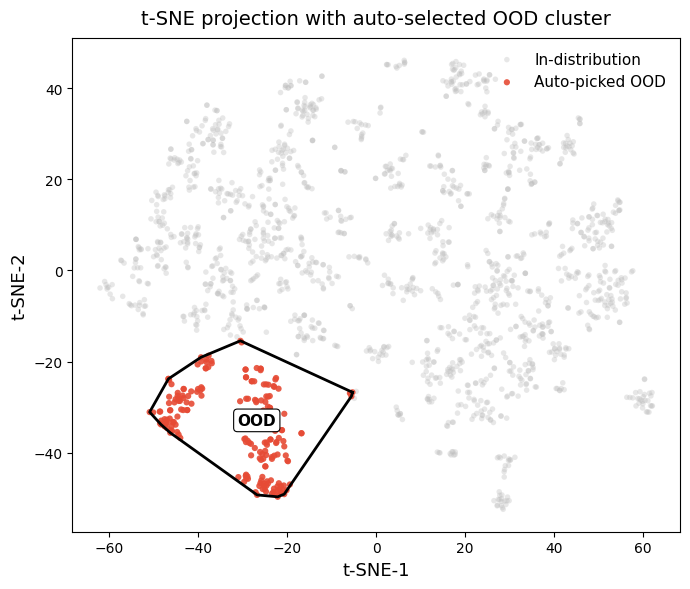

In [42]:
# =============================================
# Auto-pick a clear OOD cluster for plotting + evaluation
# Finds a compact, separable cluster and uses it as OOD
# =============================================

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import ConvexHull

# ---------------- Config (tune if needed) ----------------
OUTDIR = "splits_feature_autoood"
os.makedirs(OUTDIR, exist_ok=True)

RANDOM_STATE = 42
# OOD cluster size constraints (adjust to your dataset scale)
MIN_OOD = 50         # at least this many samples
MAX_OOD = 300        # at most this many samples

# HDBSCAN hyperparams (ignored if package not installed)
HDBSCAN_MIN_CLUSTER_SIZE = 35
HDBSCAN_MIN_SAMPLES = 8

# KMeans fallback search
KMEANS_K_RANGE = range(6, 11)  # try K = 6..10

# ---------------- Prepare data ----------------
# Expect df_combined and X exist already
n = min(len(df_combined), X.shape[0])
df = df_combined.iloc[:n].reset_index(drop=True)
X  = X[:n]

# Standardize features (important for distances)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ---------------- 2D embedding (UMAP -> t-SNE) ----------------
try:
    from umap import UMAP
    reducer = UMAP(n_neighbors=20, min_dist=0.12, random_state=RANDOM_STATE)
    Z = reducer.fit_transform(X_std)
    method = "UMAP"
except Exception:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, perplexity=30, learning_rate="auto",
                   n_iter=2000, random_state=RANDOM_STATE, init="pca")
    Z = reducer.fit_transform(X_std)
    method = "t-SNE"

# ---------------- Helper scoring functions ----------------
def cluster_stats(Z2d, labels2d):
    """Return per-cluster: size, centroid, mean inter-cluster distance."""
    clust_ids = [c for c in np.unique(labels2d) if c != -1]
    centroids = {c: Z2d[labels2d==c].mean(axis=0) for c in clust_ids}
    sizes     = {c: int((labels2d==c).sum()) for c in clust_ids}
    # mean distance from cluster centroid to all other cluster centroids (separation)
    sep = {}
    for c in clust_ids:
        others = [o for o in clust_ids if o != c]
        if not others:
            sep[c] = 0.0
        else:
            d = [np.linalg.norm(centroids[c]-centroids[o]) for o in others]
            sep[c] = float(np.mean(d))
    return clust_ids, sizes, centroids, sep

def pick_best_cluster(Z2d, labels2d, min_size, max_size):
    clust_ids, sizes, centroids, sep = cluster_stats(Z2d, labels2d)
    if not clust_ids:
        return None

    # silhouette per-sample and per-cluster
    try:
        sil_all = silhouette_samples(Z2d, labels2d, metric="euclidean")
        sil_c = {c: float(np.mean(sil_all[labels2d==c])) for c in clust_ids}
    except Exception:
        # if only 1 cluster or degenerate, set small silhouettes
        sil_c = {c: 0.0 for c in clust_ids}

    # normalize separation to [0,1]
    seps = np.array([sep[c] for c in clust_ids], dtype=float)
    if seps.size and seps.max() > 1e-9:
        sepnorm = {c: (sep[c]-seps.min())/(seps.max()-seps.min()+1e-9) for c in clust_ids}
    else:
        sepnorm = {c: 0.0 for c in clust_ids}

    # score = silhouette * normalized separation; apply size window
    best_c, best_score = None, -1
    for c in clust_ids:
        if not (min_size <= sizes[c] <= max_size):
            continue
        score = sil_c[c] * sepnorm[c]
        if score > best_score:
            best_score, best_c = score, c
    return best_c

# ---------------- Try HDBSCAN first ----------------
use_hdbscan = False
labels = None
try:
    import hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
                                min_samples=HDBSCAN_MIN_SAMPLES,
                                cluster_selection_epsilon=0.0,
                                metric="euclidean")
    labels_h = clusterer.fit_predict(Z)  # -1 is noise
    cand = pick_best_cluster(Z, labels_h, MIN_OOD, MAX_OOD)
    if cand is not None:
        labels = labels_h
        ood_label = cand
        use_hdbscan = True
except Exception:
    use_hdbscan = False

print(labels)
# ---------------- Fallback: KMeans if needed ----------------
if labels is None:
    from sklearn.cluster import KMeans
    best = None
    for k in KMEANS_K_RANGE:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(Z)
        cand = pick_best_cluster(Z, km.labels_, MIN_OOD, MAX_OOD)
        if cand is None: 
            continue
        # choose the candidate with the highest silhouette score among those passing constraints
        sc = silhouette_score(Z, km.labels_) if len(np.unique(km.labels_)) > 1 else -1
        if (best is None) or (sc > best[0]):
            best = (sc, km.labels_, cand)
            print("Found candidate OOD cluster with KMeans k=", k)

    print(best)
    if best is None:
        # final fallback: just take the farthest KMeans cluster from global centroid with size≥MIN_OOD
        k = max(KMEANS_K_RANGE)
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(Z)
        labels_tmp = km.labels_
        centroids = np.vstack([Z[labels_tmp==c].mean(axis=0) for c in range(k)])
        gcent = Z.mean(axis=0, keepdims=True)
        d = np.linalg.norm(centroids - gcent, axis=1)
        order = np.argsort(-d)  # farthest first
        ood_label = None
        for c in order:
            if (labels_tmp==c).sum() >= MIN_OOD:
                ood_label = c; break
        labels = labels_tmp
    else:
        _, labels, ood_label = best

if labels is None or ood_label is None:
    raise RuntimeError("Failed to find a viable OOD cluster under given constraints. "
                       "Try lowering MIN_OOD or broadening KMEANS_K_RANGE / HDBSCAN params.")

ood_mask = (labels == ood_label)

# ---------------- Save CSVs + manifest ----------------
df_out = df.copy()
df_out["cluster_auto"] = labels
df_out["is_ood"] = ood_mask
df_out[ood_mask].to_csv(os.path.join(OUTDIR, "ood.csv"), index=False)
df_out[~ood_mask].to_csv(os.path.join(OUTDIR, "id.csv"), index=False)

manifest = {
    "embedding": method,
    "algo": "HDBSCAN" if use_hdbscan else "KMeans",
    "label_ood": int(ood_label),
    "sizes": {"ood": int(ood_mask.sum()), "id": int((~ood_mask).sum())},
    "constraints": {"min_ood": MIN_OOD, "max_ood": MAX_OOD},
    "hdbscan": {
        "used": bool(use_hdbscan),
        "min_cluster_size": HDBSCAN_MIN_CLUSTER_SIZE,
        "min_samples": HDBSCAN_MIN_SAMPLES
    },
    "kmeans": {"range": list(KMEANS_K_RANGE)}
}
with open(os.path.join(OUTDIR, "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print(f"[Auto-OOD] method={method}, algo={'HDBSCAN' if use_hdbscan else 'KMeans'}, "
      f"label={ood_label}, OOD={ood_mask.sum()}, ID={(~ood_mask).sum()}")

# ---------------- Plot (Nature style: OOD highlighted) ----------------
id_color  = "#BDBDBD"
ood_color = "#E64B35"  # Nature red

plt.figure(figsize=(7,6))
ax = plt.gca()
plt.scatter(Z[~ood_mask,0], Z[~ood_mask,1], s=16, color=id_color, alpha=0.35, edgecolors="none", label="In-distribution")
plt.scatter(Z[ood_mask,0],  Z[ood_mask,1],  s=20, color=ood_color, alpha=0.90, edgecolors="none", label="Auto-picked OOD")

# convex hull for OOD cluster
pts = Z[ood_mask]
if pts.shape[0] >= 3:
    try:
        hull = ConvexHull(pts)
        loop = np.r_[hull.vertices, hull.vertices[:1]]
        ax.plot(pts[loop,0], pts[loop,1], color="k", linewidth=2.0, zorder=5)
    except Exception:
        pass

# label near centroid
cx, cy = pts[:,0].mean(), pts[:,1].mean()
ax.text(cx, cy, "OOD", fontsize=11, weight="bold", color="k",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="k", lw=0.8), zorder=6)

plt.xlabel(f"{method}-1", fontsize=13)
plt.ylabel(f"{method}-2", fontsize=13)
plt.title(f"{method} projection with auto-selected OOD cluster", fontsize=14, pad=10)
plt.legend(frameon=False, fontsize=11, loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}.pdf"), bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}.png"), bbox_inches="tight", dpi=300)
plt.show()


[KMeans] k= 8, silhouette=0.3953
[KMeans] k= 9, silhouette=0.4004
[KMeans] k=10, silhouette=0.3907
[KMeans] k=11, silhouette=0.3849
[KMeans] k=12, silhouette=0.3881
[KMeans] k=13, silhouette=0.3857
[KMeans] k=14, silhouette=0.4047
[KMeans] k=15, silhouette=0.4174
[KMeans] k=16, silhouette=0.4294
[KMeans] k=17, silhouette=0.4363
[KMeans] k=18, silhouette=0.4499
[KMeans] k=19, silhouette=0.4486
[KMeans] selected k=18 with silhouette=0.4499

[Cluster summary]
  label=  0 | size=  118 | ID
  label=  1 | size=  118 | ID
  label=  2 | size=   69 | OOD
  label=  3 | size=  112 | ID
  label=  4 | size=  147 | ID
  label=  5 | size=  153 | ID
  label=  6 | size=   72 | ID
  label=  7 | size=  108 | ID
  label=  8 | size=   92 | ID
  label=  9 | size=   98 | ID
  label= 10 | size=   98 | ID
  label= 11 | size=   50 | ID
  label= 12 | size=   61 | ID
  label= 13 | size=   92 | ID
  label= 14 | size=  105 | ID
  label= 15 | size=   28 | ID
  label= 16 | size=   65 | ID
  label= 17 | size=  119 | I

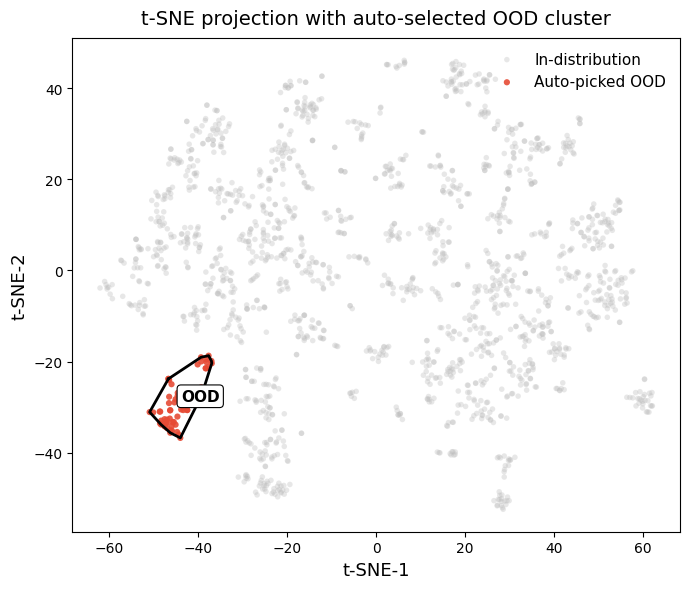

/tmp/ipykernel_2531845/3625832117.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(clust_ids), 1))


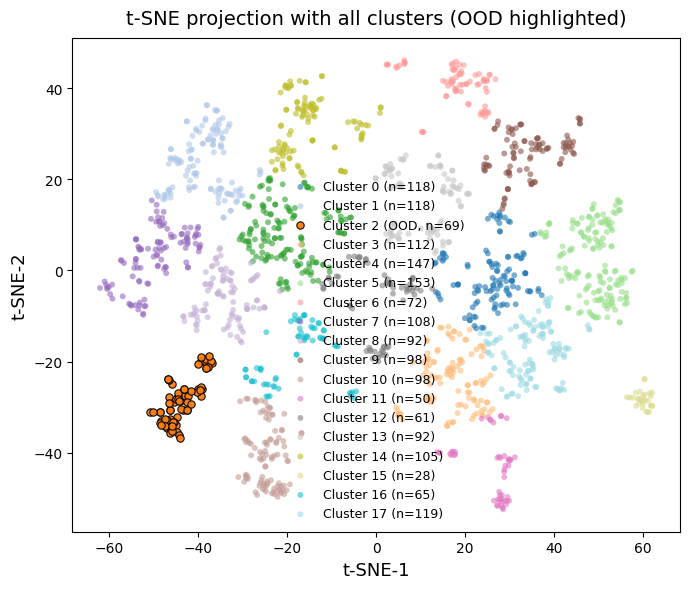

In [43]:
from sklearn.cluster import KMeans

# KMeans search: use more clusters
KMEANS_K_RANGE = range(8, 20)  # K = 10..30

# ---------------- Run KMeans for several K and pick best global clustering ----------------
best_sil = None
best_k = None
best_labels = None

for k in KMEANS_K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(Z)
    labels_k = km.labels_

    # need at least 2 clusters for silhouette
    if len(np.unique(labels_k)) < 2:
        continue

    sc = silhouette_score(Z, labels_k)
    print(f"[KMeans] k={k:2d}, silhouette={sc:.4f}")

    if (best_sil is None) or (sc > best_sil):
        best_sil = sc
        best_k = k
        best_labels = labels_k

if best_labels is None:
    raise RuntimeError("KMeans failed to produce a valid clustering over the given K range.")

labels = best_labels
print(f"[KMeans] selected k={best_k} with silhouette={best_sil:.4f}")

# ---------------- Pick OOD cluster within the chosen K ----------------
ood_label = pick_best_cluster(Z, labels, MIN_OOD, MAX_OOD)

# Fallback: if pick_best_cluster returns None (should be rare), choose farthest cluster
if ood_label is None:
    clust_ids = np.unique(labels)
    centroids = np.vstack([Z[labels == c].mean(axis=0) for c in clust_ids])
    gcent = Z.mean(axis=0, keepdims=True)
    d = np.linalg.norm(centroids - gcent, axis=1)
    ood_label = int(clust_ids[np.argmax(d)])

ood_mask = (labels == ood_label)

# ---------------- Print cluster summary ----------------
unique_labels = np.unique(labels)
print("\n[Cluster summary]")
for c in unique_labels:
    mask = (labels == c)
    size = int(mask.sum())
    tag = "OOD" if c == ood_label else "ID"
    print(f"  label={c:3d} | size={size:5d} | {tag}")

# ---------------- Save CSVs + manifest ----------------
# df_out = df.copy()
# df_out["cluster_auto"] = labels
# df_out["is_ood"] = ood_mask
# df_out[ood_mask].to_csv(os.path.join(OUTDIR, "ood.csv"), index=False)
# df_out[~ood_mask].to_csv(os.path.join(OUTDIR, "id.csv"), index=False)

manifest = {
    "embedding": method,
    "algo": "KMeans",
    "k_selected": int(best_k),
    "label_ood": int(ood_label),
    "sizes": {"ood": int(ood_mask.sum()), "id": int((~ood_mask).sum())},
    "kmeans": {"range": list(KMEANS_K_RANGE)}
}
with open(os.path.join(OUTDIR, "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print(f"[Auto-OOD] method={method}, algo=KMeans, k={best_k}, "
      f"label={ood_label}, OOD={ood_mask.sum()}, ID={(~ood_mask).sum()}")

# ---------------- Plot 1: Nature-style (ID vs OOD) ----------------
id_color  = "#BDBDBD"
ood_color = "#E64B35"  # Nature red

plt.figure(figsize=(7,6))
ax = plt.gca()
plt.scatter(Z[~ood_mask,0], Z[~ood_mask,1], s=16, color=id_color, alpha=0.35,
            edgecolors="none", label="In-distribution")
plt.scatter(Z[ood_mask,0],  Z[ood_mask,1],  s=20, color=ood_color, alpha=0.90,
            edgecolors="none", label="Auto-picked OOD")

# convex hull for OOD cluster
pts = Z[ood_mask]
if pts.shape[0] >= 3:
    try:
        hull = ConvexHull(pts)
        loop = np.r_[hull.vertices, hull.vertices[:1]]
        ax.plot(pts[loop,0], pts[loop,1], color="k", linewidth=2.0, zorder=5)
    except Exception:
        pass

# label near centroid
cx, cy = pts[:,0].mean(), pts[:,1].mean()
ax.text(cx, cy, "OOD", fontsize=11, weight="bold", color="k",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="k", lw=0.8), zorder=6)

plt.xlabel(f"{method}-1", fontsize=13)
plt.ylabel(f"{method}-2", fontsize=13)
plt.title(f"{method} projection with auto-selected OOD cluster", fontsize=14, pad=10)
plt.legend(frameon=False, fontsize=11, loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}.pdf"), bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}.png"), bbox_inches="tight", dpi=300)
plt.show()

# ---------------- Plot 2: All clusters in different colours ----------------
plt.figure(figsize=(7,6))
ax = plt.gca()

clust_ids = list(unique_labels)
cmap = plt.cm.get_cmap("tab20", max(len(clust_ids), 1))

for idx, c in enumerate(clust_ids):
    mask = (labels == c)
    # highlight OOD cluster with thicker edge + label suffix
    if c == ood_label:
        label = f"Cluster {c} (OOD, n={mask.sum()})"
        s = 28
        ec = "k"
        lw = 0.8
        alpha = 0.95
    else:
        label = f"Cluster {c} (n={mask.sum()})"
        s = 18
        ec = "none"
        lw = 0.0
        alpha = 0.6

    plt.scatter(
        Z[mask, 0],
        Z[mask, 1],
        s=s,
        color=cmap(idx),
        alpha=alpha,
        edgecolors=ec,
        linewidths=lw,
        label=label,
    )

plt.xlabel(f"{method}-1", fontsize=13)
plt.ylabel(f"{method}-2", fontsize=13)
plt.title(f"{method} projection with all clusters (OOD highlighted)", fontsize=14, pad=10)
plt.legend(frameon=False, fontsize=9, loc="best", ncol=1)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}_clusters.png"),
            bbox_inches="tight", dpi=300)
plt.show()


/home/haolin/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[Auto-OOD] method=t-SNE, algo=KMeans, label=2, OOD=195, ID=1510


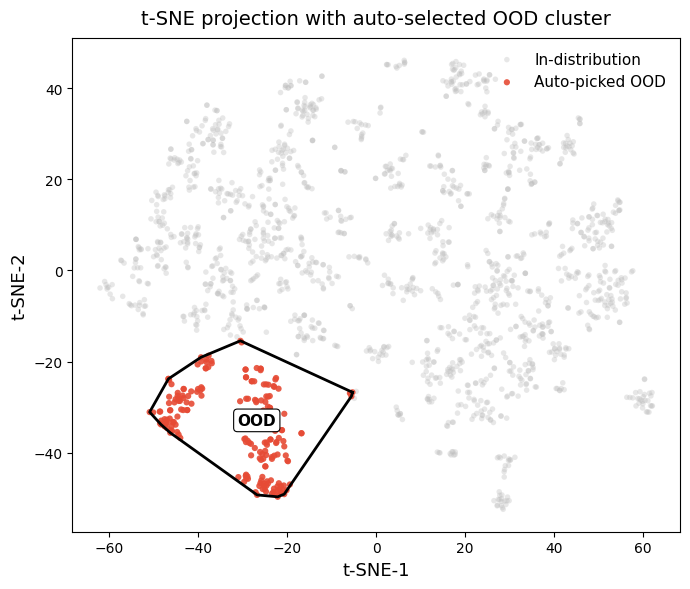

/tmp/ipykernel_2531845/2753265575.py:213: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_cats))


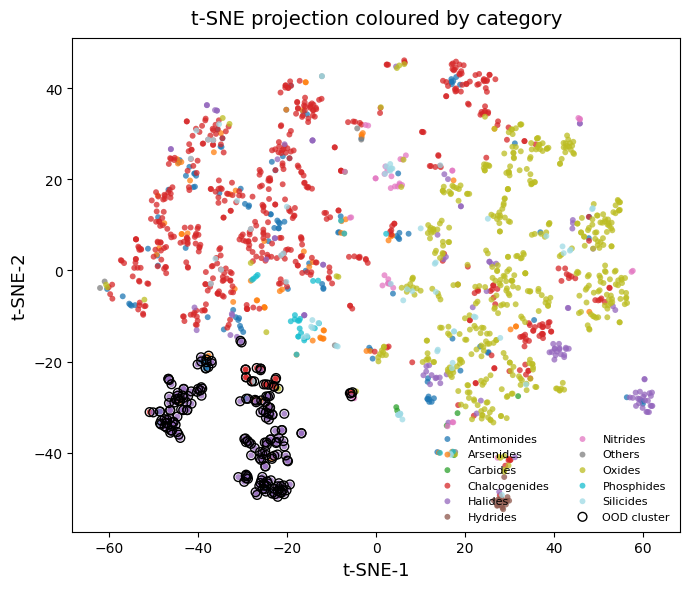

In [44]:
# =============================================
# Auto-pick a clear OOD cluster for plotting + evaluation
# Finds a compact, separable cluster and uses it as OOD
# =============================================

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import ConvexHull

# ---------------- Config (tune if needed) ----------------
OUTDIR = "splits_feature_autoood"
os.makedirs(OUTDIR, exist_ok=True)

RANDOM_STATE = 42
# OOD cluster size constraints (adjust to your dataset scale)
MIN_OOD = 50         # at least this many samples
MAX_OOD = 300        # at most this many samples

# HDBSCAN hyperparams (ignored if package not installed)
HDBSCAN_MIN_CLUSTER_SIZE = 35
HDBSCAN_MIN_SAMPLES = 8

# KMeans fallback search
KMEANS_K_RANGE = range(6, 11)  # try K = 6..10

# ---------------- Prepare data ----------------
# Expect df_combined and X exist already
n = min(len(df_combined), X.shape[0])
df = df_combined.iloc[:n].reset_index(drop=True)
X  = X[:n]

# Standardize features (important for distances)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ---------------- 2D embedding (UMAP -> t-SNE) ----------------
try:
    from umap import UMAP
    reducer = UMAP(n_neighbors=20, min_dist=0.12, random_state=RANDOM_STATE)
    Z = reducer.fit_transform(X_std)
    method = "UMAP"
except Exception:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, perplexity=30, learning_rate="auto",
                   n_iter=2000, random_state=RANDOM_STATE, init="pca")
    Z = reducer.fit_transform(X_std)
    method = "t-SNE"

# ---------------- Helper scoring functions ----------------
def cluster_stats(Z2d, labels2d):
    """Return per-cluster: size, centroid, mean inter-cluster distance."""
    clust_ids = [c for c in np.unique(labels2d) if c != -1]
    centroids = {c: Z2d[labels2d==c].mean(axis=0) for c in clust_ids}
    sizes     = {c: int((labels2d==c).sum()) for c in clust_ids}
    sep = {}
    for c in clust_ids:
        others = [o for o in clust_ids if o != c]
        if not others:
            sep[c] = 0.0
        else:
            d = [np.linalg.norm(centroids[c]-centroids[o]) for o in others]
            sep[c] = float(np.mean(d))
    return clust_ids, sizes, centroids, sep

def pick_best_cluster(Z2d, labels2d, min_size, max_size):
    clust_ids, sizes, centroids, sep = cluster_stats(Z2d, labels2d)
    if not clust_ids:
        return None

    try:
        sil_all = silhouette_samples(Z2d, labels2d, metric="euclidean")
        sil_c = {c: float(np.mean(sil_all[labels2d==c])) for c in clust_ids}
    except Exception:
        sil_c = {c: 0.0 for c in clust_ids}

    # normalized separation
    seps = np.array([sep[c] for c in clust_ids], dtype=float)
    if seps.size and seps.max() > 1e-9:
        sepnorm = {c: (sep[c]-seps.min())/(seps.max()-seps.min()+1e-9) for c in clust_ids}
    else:
        sepnorm = {c: 0.0 for c in clust_ids}

    best_c, best_score = None, -1
    for c in clust_ids:
        if not (min_size <= sizes[c] <= max_size):
            continue
        score = sil_c[c] * sepnorm[c]
        if score > best_score:
            best_score, best_c = score, c
    return best_c

# ---------------- Try HDBSCAN first ----------------
use_hdbscan = False
labels = None
try:
    import hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
                                min_samples=HDBSCAN_MIN_SAMPLES,
                                cluster_selection_epsilon=0.0,
                                metric="euclidean")
    labels_h = clusterer.fit_predict(Z)
    cand = pick_best_cluster(Z, labels_h, MIN_OOD, MAX_OOD)
    if cand is not None:
        labels = labels_h
        ood_label = cand
        use_hdbscan = True
except Exception:
    use_hdbscan = False

# ---------------- Fallback: KMeans if needed ----------------
if labels is None:
    from sklearn.cluster import KMeans
    best = None
    for k in KMEANS_K_RANGE:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(Z)
        cand = pick_best_cluster(Z, km.labels_, MIN_OOD, MAX_OOD)
        if cand is None:
            continue
        sc = silhouette_score(Z, km.labels_) if len(np.unique(km.labels_)) > 1 else -1
        if (best is None) or (sc > best[0]):
            best = (sc, km.labels_, cand)

    if best is None:
        k = max(KMEANS_K_RANGE)
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(Z)
        labels_tmp = km.labels_
        centroids = np.vstack([Z[labels_tmp==c].mean(axis=0) for c in range(k)])
        gcent = Z.mean(axis=0, keepdims=True)
        d = np.linalg.norm(centroids - gcent, axis=1)
        order = np.argsort(-d)
        ood_label = None
        for c in order:
            if (labels_tmp==c).sum() >= MIN_OOD:
                ood_label = c; break
        labels = labels_tmp
    else:
        _, labels, ood_label = best

if labels is None or ood_label is None:
    raise RuntimeError("Failed to find a viable OOD cluster.")


ood_mask = (labels == ood_label)

# ---------------- Save CSVs + manifest ----------------
df_out = df.copy()
df_out["cluster_auto"] = labels
df_out["is_ood"] = ood_mask
df_out[ood_mask].to_csv(os.path.join(OUTDIR, "ood.csv"), index=False)
df_out[~ood_mask].to_csv(os.path.join(OUTDIR, "id.csv"), index=False)

manifest = {
    "embedding": method,
    "algo": "HDBSCAN" if use_hdbscan else "KMeans",
    "label_ood": int(ood_label),
    "sizes": {"ood": int(ood_mask.sum()), "id": int((~ood_mask).sum())},
    "constraints": {"min_ood": MIN_OOD, "max_ood": MAX_OOD},
    "hdbscan": {
        "used": bool(use_hdbscan),
        "min_cluster_size": HDBSCAN_MIN_CLUSTER_SIZE,
        "min_samples": HDBSCAN_MIN_SAMPLES
    },
    "kmeans": {"range": list(KMEANS_K_RANGE)}
}
with open(os.path.join(OUTDIR, "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print(f"[Auto-OOD] method={method}, algo={'HDBSCAN' if use_hdbscan else 'KMeans'}, "
      f"label={ood_label}, OOD={ood_mask.sum()}, ID={(~ood_mask).sum()}")


# ---------------------------------------------------
#  PLOT 1: Auto-selected OOD (your original plot)
# ---------------------------------------------------
id_color  = "#BDBDBD"
ood_color = "#E64B35"  # Nature red

plt.figure(figsize=(7,6))
ax = plt.gca()
plt.scatter(Z[~ood_mask,0], Z[~ood_mask,1], s=16, color=id_color, alpha=0.35, edgecolors="none", label="In-distribution")
plt.scatter(Z[ood_mask,0],  Z[ood_mask,1],  s=20, color=ood_color, alpha=0.90, edgecolors="none", label="Auto-picked OOD")

pts = Z[ood_mask]
if pts.shape[0] >= 3:
    try:
        hull = ConvexHull(pts)
        loop = np.r_[hull.vertices, hull.vertices[:1]]
        ax.plot(pts[loop,0], pts[loop,1], color="k", linewidth=2.0, zorder=5)
    except Exception:
        pass

cx, cy = pts[:,0].mean(), pts[:,1].mean()
ax.text(cx, cy, "OOD", fontsize=11, weight="bold", color="k",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="k", lw=0.8), zorder=6)

plt.xlabel(f"{method}-1", fontsize=13)
plt.ylabel(f"{method}-2", fontsize=13)
plt.title(f"{method} projection with auto-selected OOD cluster", fontsize=14, pad=10)
plt.legend(frameon=False, fontsize=11, loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}.pdf"), bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}.png"), bbox_inches="tight", dpi=300)
plt.show()


# ---------------------------------------------------
#  PLOT 2: Embedding coloured by CATEGORY
# ---------------------------------------------------
categories = df["category"].astype(str)
unique_cats = sorted(categories.unique())

cmap = plt.cm.get_cmap("tab20", len(unique_cats))

plt.figure(figsize=(7,6))
for i, cat in enumerate(unique_cats):
    mask = (categories == cat)
    plt.scatter(
        Z[mask, 0],
        Z[mask, 1],
        s=18,
        color=cmap(i),
        alpha=0.75,
        label=cat,
        edgecolors="none",
    )

# Overlay OOD with black circles
plt.scatter(
    Z[ood_mask,0],
    Z[ood_mask,1],
    s=40,
    facecolors="none",
    edgecolors="black",
    linewidths=1.0,
    label="OOD cluster"
)

plt.xlabel(f"{method}-1", fontsize=13)
plt.ylabel(f"{method}-2", fontsize=13)
plt.title(f"{method} projection coloured by category", fontsize=14, pad=10)
plt.legend(frameon=False, fontsize=8, loc="best", ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"{method.lower()}_by_category.pdf"), bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, f"{method.lower()}_by_category.png"), bbox_inches="tight", dpi=300)
plt.show()


/home/haolin/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[Auto-OOD] method=t-SNE, algo=KMeans, label=2, OOD=195, ID=1510


/home/haolin/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


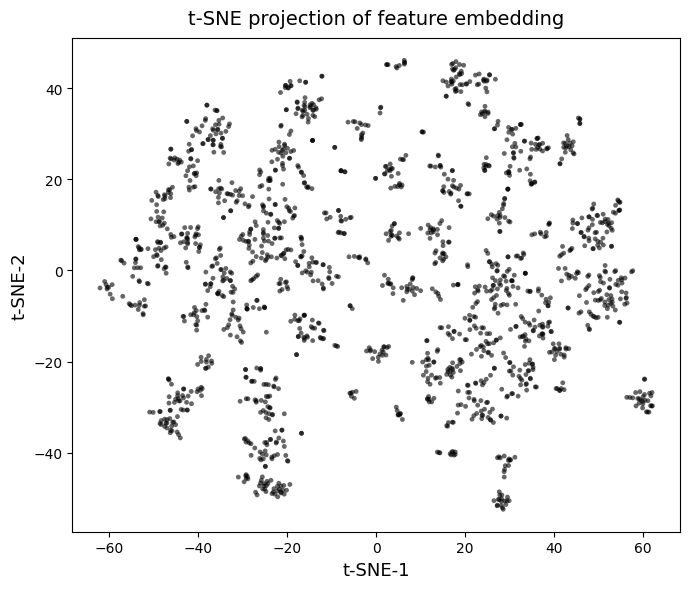

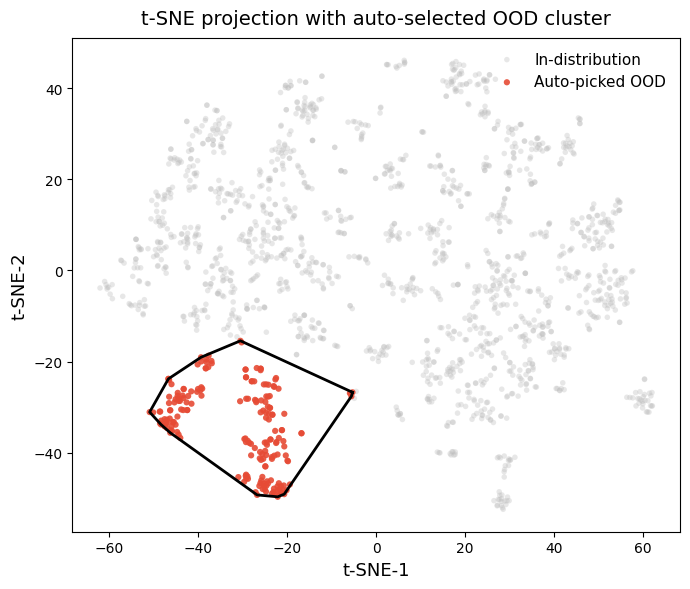

/tmp/ipykernel_2531845/3764423076.py:249: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_cats))
/tmp/ipykernel_2531845/3764423076.py:278: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, fontsize=8, loc="best", ncol=2)


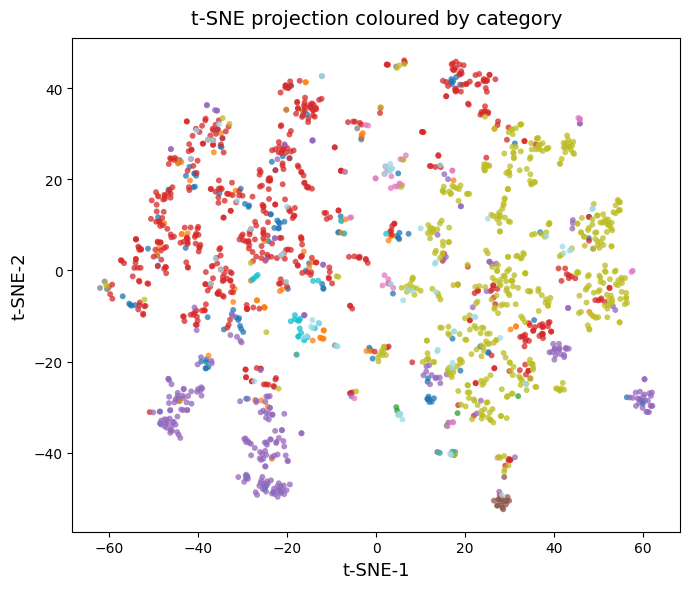

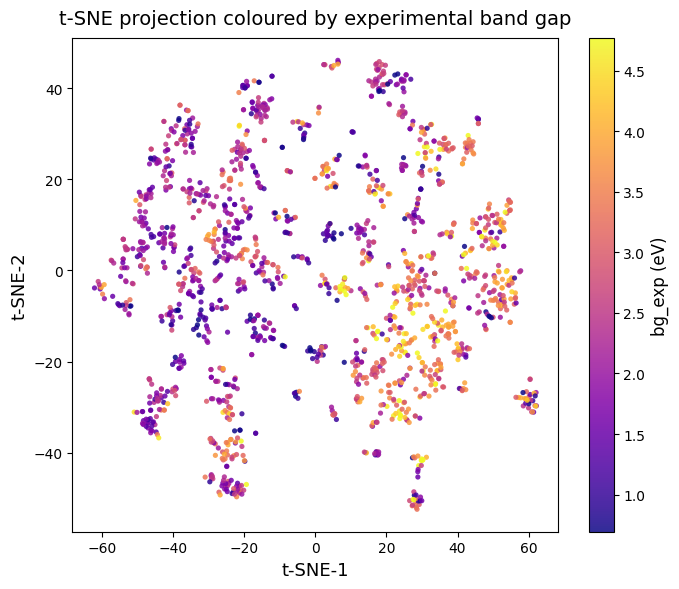

In [45]:
# =============================================
# Auto-pick a clear OOD cluster for plotting + evaluation
# Finds a compact, separable cluster and uses it as OOD
# =============================================

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import ConvexHull


# ---------------- Config (tune if needed) ----------------
OUTDIR = "splits_feature_autoood"
os.makedirs(OUTDIR, exist_ok=True)

RANDOM_STATE = 42
# OOD cluster size constraints (adjust to your dataset scale)
MIN_OOD = 50         # at least this many samples
MAX_OOD = 300        # at most this many samples

# HDBSCAN hyperparams (ignored if package not installed)
HDBSCAN_MIN_CLUSTER_SIZE = 35
HDBSCAN_MIN_SAMPLES = 8

# KMeans fallback search
KMEANS_K_RANGE = range(6, 11)  # try K = 6..10

# ---------------- Prepare data ----------------
# Expect df_combined and X exist already
n = min(len(df_combined), X.shape[0])
df = df_combined.iloc[:n].reset_index(drop=True)
X  = X[:n]

# Standardize features (important for distances)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ---------------- 2D embedding (UMAP -> t-SNE) ----------------
try:
    from umap import UMAP
    reducer = UMAP(n_neighbors=20, min_dist=0.12, random_state=RANDOM_STATE)
    Z = reducer.fit_transform(X_std)
    method = "UMAP"
except Exception:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, perplexity=30, learning_rate="auto",
                   n_iter=2000, random_state=RANDOM_STATE, init="pca")
    Z = reducer.fit_transform(X_std)
    method = "t-SNE"

# ---------------- Helper scoring functions ----------------
def cluster_stats(Z2d, labels2d):
    """Return per-cluster: size, centroid, mean inter-cluster distance."""
    clust_ids = [c for c in np.unique(labels2d) if c != -1]
    centroids = {c: Z2d[labels2d==c].mean(axis=0) for c in clust_ids}
    sizes     = {c: int((labels2d==c).sum()) for c in clust_ids}
    sep = {}
    for c in clust_ids:
        others = [o for o in clust_ids if o != c]
        if not others:
            sep[c] = 0.0
        else:
            d = [np.linalg.norm(centroids[c]-centroids[o]) for o in others]
            sep[c] = float(np.mean(d))
    return clust_ids, sizes, centroids, sep

def pick_best_cluster(Z2d, labels2d, min_size, max_size):
    clust_ids, sizes, centroids, sep = cluster_stats(Z2d, labels2d)
    if not clust_ids:
        return None

    try:
        sil_all = silhouette_samples(Z2d, labels2d, metric="euclidean")
        sil_c = {c: float(np.mean(sil_all[labels2d==c])) for c in clust_ids}
    except Exception:
        sil_c = {c: 0.0 for c in clust_ids}

    # normalized separation
    seps = np.array([sep[c] for c in clust_ids], dtype=float)
    if seps.size and seps.max() > 1e-9:
        sepnorm = {c: (sep[c]-seps.min())/(seps.max()-seps.min()+1e-9) for c in clust_ids}
    else:
        sepnorm = {c: 0.0 for c in clust_ids}

    best_c, best_score = None, -1
    for c in clust_ids:
        if not (min_size <= sizes[c] <= max_size):
            continue
        score = sil_c[c] * sepnorm[c]
        if score > best_score:
            best_score, best_c = score, c
    return best_c

# ---------------- Try HDBSCAN first ----------------
use_hdbscan = False
labels = None
try:
    import hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
                                min_samples=HDBSCAN_MIN_SAMPLES,
                                cluster_selection_epsilon=0.0,
                                metric="euclidean")
    labels_h = clusterer.fit_predict(Z)
    cand = pick_best_cluster(Z, labels_h, MIN_OOD, MAX_OOD)
    if cand is not None:
        labels = labels_h
        ood_label = cand
        use_hdbscan = True
except Exception:
    use_hdbscan = False

# ---------------- Fallback: KMeans if needed ----------------
if labels is None:
    from sklearn.cluster import KMeans
    best = None
    for k in KMEANS_K_RANGE:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(Z)
        cand = pick_best_cluster(Z, km.labels_, MIN_OOD, MAX_OOD)
        if cand is None:
            continue
        sc = silhouette_score(Z, km.labels_) if len(np.unique(km.labels_)) > 1 else -1
        if (best is None) or (sc > best[0]):
            best = (sc, km.labels_, cand)

    if best is None:
        k = max(KMEANS_K_RANGE)
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(Z)
        labels_tmp = km.labels_
        centroids = np.vstack([Z[labels_tmp==c].mean(axis=0) for c in range(k)])
        gcent = Z.mean(axis=0, keepdims=True)
        d = np.linalg.norm(centroids - gcent, axis=1)
        order = np.argsort(-d)
        ood_label = None
        for c in order:
            if (labels_tmp==c).sum() >= MIN_OOD:
                ood_label = c; break
        labels = labels_tmp
    else:
        _, labels, ood_label = best

if labels is None or ood_label is None:
    raise RuntimeError("Failed to find a viable OOD cluster.")

ood_mask = (labels == ood_label)

# ---------------- Save CSVs + manifest ----------------
df_out = df.copy()
df_out["cluster_auto"] = labels
df_out["is_ood"] = ood_mask
# df_out[ood_mask].to_csv(os.path.join(OUTDIR, "ood.csv"), index=False)
# df_out[~ood_mask].to_csv(os.path.join(OUTDIR, "id.csv"), index=False)

# manifest = {
#     "embedding": method,
#     "algo": "HDBSCAN" if use_hdbscan else "KMeans",
#     "label_ood": int(ood_label),
#     "sizes": {"ood": int(ood_mask.sum()), "id": int((~ood_mask).sum())},
#     "constraints": {"min_ood": MIN_OOD, "max_ood": MAX_OOD},
#     "hdbscan": {
#         "used": bool(use_hdbscan),
#         "min_cluster_size": HDBSCAN_MIN_CLUSTER_SIZE,
#         "min_samples": HDBSCAN_MIN_SAMPLES
#     },
#     "kmeans": {"range": list(KMEANS_K_RANGE)}
# }
# with open(os.path.join(OUTDIR, "manifest.json"), "w") as f:
#     json.dump(manifest, f, indent=2)

print(f"[Auto-OOD] method={method}, algo={'HDBSCAN' if use_hdbscan else 'KMeans'}, "
      f"label={ood_label}, OOD={ood_mask.sum()}, ID={(~ood_mask).sum()}")


# ===================================================
#  PLOT 0: t-SNE with all points in black
# ===================================================
from sklearn.manifold import TSNE

Z_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    n_iter=2000,
    random_state=RANDOM_STATE,
    init="pca",
).fit_transform(X_std)

plt.figure(figsize=(7, 6))
plt.scatter(
    Z_tsne[:, 0],
    Z_tsne[:, 1],
    s=12,
    color="black",
    alpha=0.6,
    edgecolors="none",
)
plt.xlabel("t-SNE-1", fontsize=13)
plt.ylabel("t-SNE-2", fontsize=13)
plt.title("t-SNE projection of feature embedding", fontsize=14, pad=10)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "tsne_all_black.pdf"),
            bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, "tsne_all_black.png"),
            bbox_inches="tight", dpi=300)
plt.show()


# ---------------------------------------------------
#  PLOT 1: Auto-selected OOD (same as original, no 'OOD' text)
# ---------------------------------------------------
id_color  = "#BDBDBD"
ood_color = "#E64B35"  # Nature red

plt.figure(figsize=(7,6))
ax = plt.gca()
plt.scatter(Z[~ood_mask,0], Z[~ood_mask,1], s=16, color=id_color, alpha=0.35,
            edgecolors="none", label="In-distribution")
plt.scatter(Z[ood_mask,0],  Z[ood_mask,1],  s=20, color=ood_color, alpha=0.90,
            edgecolors="none", label="Auto-picked OOD")

pts = Z[ood_mask]
if pts.shape[0] >= 3:
    try:
        hull = ConvexHull(pts)
        loop = np.r_[hull.vertices, hull.vertices[:1]]
        ax.plot(pts[loop,0], pts[loop,1], color="k", linewidth=2.0, zorder=5)
    except Exception:
        pass

# NOTE: removed the ax.text(...) block so there is no "OOD" text label

plt.xlabel(f"{method}-1", fontsize=13)
plt.ylabel(f"{method}-2", fontsize=13)
plt.title(f"{method} projection with auto-selected OOD cluster", fontsize=14, pad=10)
plt.legend(frameon=False, fontsize=11, loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}_no_label.pdf"),
            bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, f"autoood_{method.lower()}_no_label.png"),
            bbox_inches="tight", dpi=300)
plt.show()


# ---------------------------------------------------
#  PLOT 2: Embedding coloured by CATEGORY
# ---------------------------------------------------
categories = df["category"].astype(str)
unique_cats = sorted(categories.unique())

cmap = plt.cm.get_cmap("tab20", len(unique_cats))

plt.figure(figsize=(7,6))
for i, cat in enumerate(unique_cats):
    mask = (categories == cat)
    plt.scatter(
        Z[mask, 0],
        Z[mask, 1],
        s=18,
        color=cmap(i),
        alpha=0.75,
        # label=cat,
        edgecolors="none",
    )

# # Overlay OOD with black circles
# plt.scatter(
#     Z[ood_mask,0],
#     Z[ood_mask,1],
#     s=40,
#     facecolors="none",
#     edgecolors="black",
#     linewidths=1.0,
#     label="OOD cluster"
# )

plt.xlabel(f"{method}-1", fontsize=13)
plt.ylabel(f"{method}-2", fontsize=13)
plt.title(f"{method} projection coloured by category", fontsize=14, pad=10)
plt.legend(frameon=False, fontsize=8, loc="best", ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"{method.lower()}_by_category.pdf"),
            bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, f"{method.lower()}_by_category.png"),
            bbox_inches="tight", dpi=300)
plt.show()


# ===================================================
#  PLOT 3: t-SNE coloured by bg_exp (extra figure, no code modified above)
# ===================================================
import matplotlib.colors as mcolors

# 兼容 df_combine / df_combined 两种命名
if "df_combine" in globals():
    df_bg = df_combine.iloc[:n].reset_index(drop=True)
else:
    df_bg = df_combined.iloc[:n].reset_index(drop=True)

bg = pd.to_numeric(df_bg["bg_exp"], errors="coerce").to_numpy()
mask_valid = np.isfinite(bg)

plt.figure(figsize=(7, 6))

# 使用稳健色标，避免极端值拉爆
bg_valid = bg[mask_valid]
vmin, vmax = np.nanpercentile(bg_valid, [2, 98])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

sc = plt.scatter(
    Z_tsne[mask_valid, 0],
    Z_tsne[mask_valid, 1],
    s=14,
    c=bg_valid,
    cmap="plasma",
    norm=norm,
    alpha=0.85,
    edgecolors="none",
)

# bg_exp 缺失的点（可选，但推荐保留）
if (~mask_valid).any():
    plt.scatter(
        Z_tsne[~mask_valid, 0],
        Z_tsne[~mask_valid, 1],
        s=14,
        color="#CFCFCF",
        alpha=0.6,
        edgecolors="none",
        label="bg_exp missing",
    )
    plt.legend(frameon=False, fontsize=10)

cbar = plt.colorbar(sc)
cbar.set_label("bg_exp (eV)", fontsize=12)

plt.xlabel("t-SNE-1", fontsize=13)
plt.ylabel("t-SNE-2", fontsize=13)
plt.title("t-SNE projection coloured by experimental band gap", fontsize=14, pad=10)
plt.tight_layout()

plt.savefig(os.path.join(OUTDIR, "tsne_by_bgexp.pdf"),
            bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, "tsne_by_bgexp.png"),
            bbox_inches="tight", dpi=300)
plt.show()




/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 3 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 12 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountere

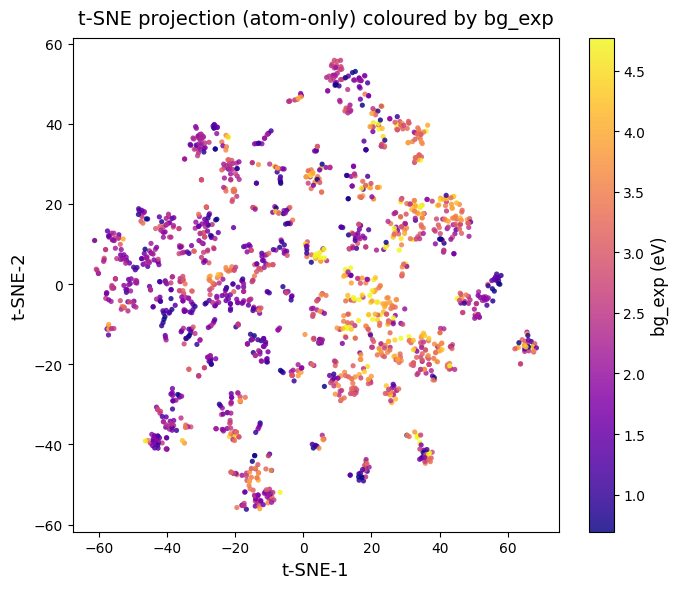

In [46]:
from data_process.dataloader import extract_features_atom_only

X_atom, y_atom = extract_features_atom_only(x_dataset)
n = min(len(df_combined), X_atom.shape[0])

# 保证样本数对齐
n_atom = X_atom.shape[0]
df_atom = df_combined.iloc[:n_atom].reset_index(drop=True)

# 标准化（非常重要）
scaler_atom = StandardScaler()
X_atom_std = scaler_atom.fit_transform(X_atom)

# t-SNE
Z_atom_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    n_iter=2000,
    random_state=RANDOM_STATE,
    init="pca",
).fit_transform(X_atom_std)

bg = pd.to_numeric(df_atom["bg_exp"], errors="coerce").to_numpy()
mask_valid = np.isfinite(bg)

plt.figure(figsize=(7, 6))

# 稳健色标范围（避免极端值“拉爆”色条）
bg_valid = bg[mask_valid]
vmin, vmax = np.nanpercentile(bg_valid, [2, 98])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

sc = plt.scatter(
    Z_atom_tsne[mask_valid, 0],
    Z_atom_tsne[mask_valid, 1],
    s=14,
    c=bg_valid,
    cmap="plasma",   # 想换就改这里： "magma" / "inferno" / "turbo"
    norm=norm,
    alpha=0.85,
    edgecolors="none",
)

# bg_exp 缺失点用灰色画出来（可选）
if (~mask_valid).any():
    plt.scatter(
        Z_atom_tsne[~mask_valid, 0],
        Z_atom_tsne[~mask_valid, 1],
        s=14,
        color="#CFCFCF",
        alpha=0.6,
        edgecolors="none",
        label="bg_exp missing",
    )
    plt.legend(frameon=False, fontsize=10, loc="best")

cbar = plt.colorbar(sc)
cbar.set_label("bg_exp (eV)", fontsize=12)

plt.xlabel("t-SNE-1", fontsize=13)
plt.ylabel("t-SNE-2", fontsize=13)
plt.title("t-SNE projection (atom-only) coloured by bg_exp", fontsize=14, pad=10)
plt.tight_layout()

plt.savefig(os.path.join(OUTDIR, "tsne_atom_only_by_bgexp.pdf"),
            bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, "tsne_atom_only_by_bgexp.png"),
            bbox_inches="tight", dpi=300)
plt.show()


/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 3 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: 12 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/haolin/.local/lib/python3.10/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountere

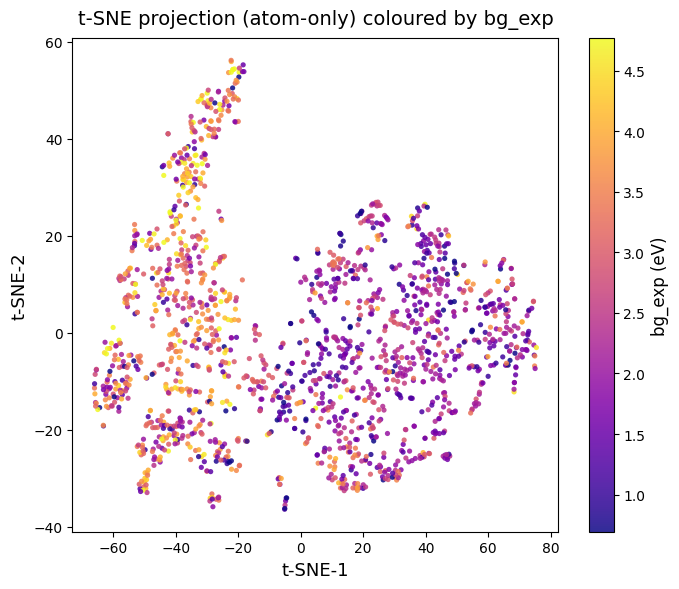

In [47]:
from data_process.dataloader import extract_features_atom_num

X_atom, y_atom = extract_features_atom_num(x_dataset)
n = min(len(df_combined), X_atom.shape[0])

# 保证样本数对齐
n_atom = X_atom.shape[0]
df_atom = df_combined.iloc[:n_atom].reset_index(drop=True)

# 标准化（非常重要）
scaler_atom = StandardScaler()
X_atom_std = scaler_atom.fit_transform(X_atom)

# t-SNE
Z_atom_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    n_iter=2000,
    random_state=RANDOM_STATE,
    init="pca",
).fit_transform(X_atom_std)

bg = pd.to_numeric(df_atom["bg_exp"], errors="coerce").to_numpy()
mask_valid = np.isfinite(bg)

plt.figure(figsize=(7, 6))

# 稳健色标范围（避免极端值“拉爆”色条）
bg_valid = bg[mask_valid]
vmin, vmax = np.nanpercentile(bg_valid, [2, 98])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

sc = plt.scatter(
    Z_atom_tsne[mask_valid, 0],
    Z_atom_tsne[mask_valid, 1],
    s=14,
    c=bg_valid,
    cmap="plasma",   # 想换就改这里： "magma" / "inferno" / "turbo"
    norm=norm,
    alpha=0.85,
    edgecolors="none",
)

# bg_exp 缺失点用灰色画出来（可选）
if (~mask_valid).any():
    plt.scatter(
        Z_atom_tsne[~mask_valid, 0],
        Z_atom_tsne[~mask_valid, 1],
        s=14,
        color="#CFCFCF",
        alpha=0.6,
        edgecolors="none",
        label="bg_exp missing",
    )
    plt.legend(frameon=False, fontsize=10, loc="best")

cbar = plt.colorbar(sc)
cbar.set_label("bg_exp (eV)", fontsize=12)

plt.xlabel("t-SNE-1", fontsize=13)
plt.ylabel("t-SNE-2", fontsize=13)
plt.title("t-SNE projection (atom-only) coloured by bg_exp", fontsize=14, pad=10)
plt.tight_layout()

plt.savefig(os.path.join(OUTDIR, "tsne_atom_only_by_bgexp.pdf"),
            bbox_inches="tight", dpi=600)
plt.savefig(os.path.join(OUTDIR, "tsne_atom_only_by_bgexp.png"),
            bbox_inches="tight", dpi=300)
plt.show()


In [48]:
import importlib
import data_process.dataloader as dl
importlib.reload(dl)
from data_process.dataloader import extract_features_atom_num
